In [906]:
%load_ext autoreload
%autoreload 2

import os
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import iqr
from scipy.interpolate import interp1d
from astropy.coordinates import SkyCoord, EarthLocation, AltAz, ICRS
from astropy.time import Time
from astropy.timeseries import LombScargle
from astropy.wcs import WCS
from astropy import units as u
from astropy.io import fits
from astropy import constants
from astropy.modeling.models import BlackBody
from astropy.visualization import quantity_support

from tqdm import tqdm

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [907]:
#Move up to RAFTS directory
if os.getcwd().endswith('/RAFTS'):
    pass
else:
    os.chdir('../../')
    print(os.getcwd())

In [908]:
%load_ext autoreload
%autoreload 2
from utils import filt_interp, dpar, dtan, lamb_eff_md, dcr_offset, celest_to_pa
from utils import inverse_Teff, inverseTeff, inverseWeff, lorentzian, find_min_max_adjacent 
from utils import variance_weighted_mean, chrDistAng
import globals
globals.initialize()
from config import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [909]:
ROOTDIR

'/Users/fbianco/RAFTS/'

In [910]:
#PARAMS
flare_ref_pos = globals.flare_ref_pos
flr_id = globals.flareid

filters = ['u', 'g', 'r', 'i', 'z', 'y']

filtercolors = {
            "u": "#66CCEE",
            "g": "#228833",
            "r": "#CCBB44",
            "i": "#EE6677",
            "z": "#AA3377",
            "y": "#4B3713",
            " ": None}

In [911]:
# Read in data for analysis
dpar_arr = np.load('Outdata/dpar_arr.npy')
dpar_raw = np.load('Outdata/dpar_raw.npy')
dpar_subtracted = np.load('Outdata/dpar_subtracted.npy')
dpar_smoothed = np.load('Outdata/dpar_smoothed.npy')
dparerr_smoothed = np.load('Outdata/dparerr_smoothed.npy')
dparerr = np.load('Outdata/dparerr.npy')
delta_g_mag = np.load('Outdata/delta_g_mag.npy')
delta_g_mag_err = np.load('Outdata/delta_g_mag_err.npy')
ras = np.load('Outdata/ras.npy')
decs = np.load('Outdata/decs.npy')
raerrs = np.load('Outdata/raerrs.npy')
decerrs = np.load('Outdata/decerrs.npy')
times = np.load('Outdata/times.npy')
dt_sec = np.load('Outdata/dt_sec.npy')
imnames_timeordered = np.load('Outdata/imnames_timeordered.npy')
imnames_timeordered_S18 = np.load('Outdata/imnames_timeordered_S18.npy')

# Dataframe version
useDF = True
if useDF:
    flare_df = pd.read_csv("Outdata/flare_df.csv", index_col=0)
    flare_astrometry = pd.read_csv("Outdata/main_df_GaussPSF.csv")

    # Ensure the 'mjd' and 'time' columns are rounded to avoid floating point precision issues during merge
    flare_df['mjd'] = flare_df['mjd'].round(10)
    flare_astrometry['time'] = flare_astrometry['time'].round(10)

    flare_info = flare_df[['mjd', 'time', 'dpar_smoothed', 'dparerr_smoothed', 'g_mag', 'g_mag_error', 'am']].merge(
        flare_astrometry[['RA', 'DEC', 'RA_ERR', 'DEC_ERR', 'time']][flare_astrometry['id'] == flr_id], left_on="mjd", right_on="time")

    flare_info.drop('time_y', axis=1, inplace=True)  # Drop the duplicate 'time' column from astrometry
    dpar_smoothed = flare_info['dpar_smoothed'].values
    dparerr_smoothed = flare_info['dparerr_smoothed'].values
    ras = flare_info['RA'].values
    decs = flare_info['DEC'].values
    raerrs = flare_info['RA_ERR'].values
    decerrs = flare_info['DEC_ERR'].values
    times = flare_info['mjd'].values
    delta_g_mag = flare_info['g_mag'].values
    delta_g_mag_err = flare_info['g_mag_error'].values
tSec = (times - times[0]) * DAY2SEC

In [912]:
flare_info.head()

,mjd,time_x,dpar_smoothed,dparerr_smoothed,g_mag,g_mag_error,am,RA,DEC,RA_ERR,DEC_ERR
0,57374.240660,0.000000,0.044474,0.020062,-0.014983,0.046426,1.460713,45.606318,-54.951988,0.000011,0.000005
1,57374.241217,48.188013,0.029758,0.018947,0.034246,0.045075,1.463837,45.606329,-54.952008,0.000009,0.000005
2,57374.241772,96.133131,0.021292,0.018098,0.097740,0.050739,1.466965,45.606323,-54.951993,0.000011,0.000006
3,57374.242328,144.106382,0.012826,0.017173,0.049862,0.048386,1.470115,45.606323,-54.951994,0.000011,0.000006
4,57374.242878,191.623585,0.014035,0.016443,-0.152512,0.042163,1.473256,45.606343,-54.951993,0.000010,0.000005


In [913]:
flare_info.shape

(74, 11)

In [914]:
NTimestamps = flare_info.shape[0]

## $T_{eff}$ via model grid search

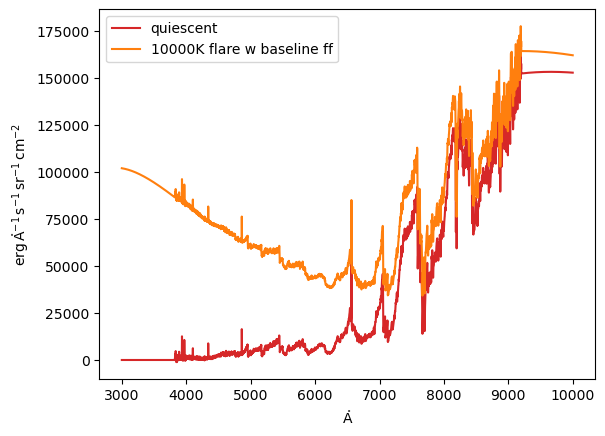

In [915]:
#test SED with and without bb
bb10k = BlackBody(temperature=10_000*u.K, scale=1*u.erg/u.s/u.cm/u.cm/u.AA/u.sr)
wav = np.arange(3_000, 10_000) * u.AA
baseline_ff = globals.FF
plx = 10.27
dist = 1_000 / plx * u.pc
Rstar = 0.1 * u.Rsun
mds = np.load('sdsstemplates/m7.active.ha.na.k_ext.npy')[int(wav[0].value):int(wav[-1].value+1)]
sdss_inds = [np.where(wav == WMIN * u.AA)[0][0], np.where(wav == WMAX * u.AA)[0][0].sum()]
C = bb10k(wav)[sdss_inds[0]:sdss_inds[1]].sum().value * (baseline_ff) / mds[sdss_inds[0]:sdss_inds[1]].sum() 
C *= 1*u.erg/u.s/u.cm/u.cm/u.AA/u.sr

with quantity_support():
    plt.figure()
    plt.plot(wav, mds * C, c='C3', label='quiescent')
    plt.plot(wav, (mds * C) + bb10k(wav) * (baseline_ff), c='C1', label='10000K flare w baseline ff')
    plt.legend()
    plt.show()

In [919]:
### Creating model grids
REDOGRID =  False
PLOTS = False

linefracdict = {'no lines':[0.0,0.0], 'lines':[0.115,0.115]}

dpar_model = {}
dmag_model = {}
weff_model = {}

bins = 401
tmax = 70_000
amax = 2
baseline_ff = globals.FF
amax_bff = amax * 0.01 / baseline_ff
    
delta_g = np.zeros([bins, bins])
weff_grid = np.zeros([bins, bins])
delta_dcr = np.zeros([bins, bins, flare_info.shape[0]])

temp_grid = np.linspace(2_000, tmax, bins)
a_grid = np.linspace(0.0, amax_bff, bins) #grid in units of baseline FF defined in globals
x_grid = flare_info.am

wav = np.arange(3_000, 10_000) * u.AA
plx = 10.27
dist = 1_000 / plx * u.pc
Rstar = 0.1 * u.Rsun
f = filt_interp('g')
bandf = f(wav) * u.AA

C = bb10k(wav)[sdss_inds[0]:sdss_inds[1]].sum().value * (baseline_ff) / mds[sdss_inds[0]:sdss_inds[1]].sum() 
C *= 1*u.erg/u.s/u.cm/u.cm/u.AA/u.sr

    
for line_setting in linefracdict:
    print(f"line setting {line_setting}")
    linefrac = linefracdict[line_setting]
    
    if line_setting == 'lines':
        filenames = [
                    'Outdata/dpar_model_lines_{0}bins_{1}tmax_{2}amax.npy'.format(bins, tmax, amax),
                    'Outdata/dmag_model_lines_{0}bins_{1}tmax_{2}amax.npy'.format(bins, tmax, amax),
                    'Outdata/weff_model_lines_{0}bins_{1}tmax_{2}amax.npy'.format(bins, tmax, amax)
            ]
        print(filenames)
        if np.array([os.path.exists(f) for f in filenames]).all() and not REDOGRID:
            print(f"Files {filenames} already exists. Skipping model generation.")
            dpar_model["lines"] = np.load(filenames[0])
            dmag_model["lines"] = np.load(filenames[1])
            weff_model["lines"] = np.load(filenames[2])
            continue
       
    elif line_setting == 'no lines':
        filenames = [
                    'Outdata/dpar_model_nolines_{0}bins_{1}tmax_{2}amax.npy'.format(bins, tmax, amax),
                    'Outdata/dmag_model_nolines_{0}bins_{1}tmax_{2}amax.npy'.format(bins, tmax, amax),
                    'Outdata/weff_model_nolines_{0}bins_{1}tmax_{2}amax.npy'.format(bins, tmax, amax)
            ]
        print(filenames)
        if np.array([os.path.exists(f) for f in filenames]).all() and not REDOGRID:
            print(f"Files {filenames} already exists. Skipping model generation.")
            dpar_model["nolines"] = np.load(filenames[0])
            dmag_model["nolines"] = np.load(filenames[1])
            weff_model["nolines"] = np.load(filenames[2])
            continue

    print(f"size of grid {len(temp_grid)}")
    for i, t in tqdm(enumerate(temp_grid)):
        for j, a in enumerate(a_grid):
            
            bb = BlackBody(temperature = t * u.K, scale = 1*u.erg/u.s/u.cm/u.cm/u.AA/u.sr)
            sed_bb = bb(wav)
            sed_dm = mds * C

            ##Lines

            maxpt = wav[np.where(bandf == bandf.max())[0][0]]
            band_edges = (wav[bandf == bandf[(bandf > 0*u.AA) * (wav < maxpt)].min()][0], 
                            wav[bandf == bandf[(bandf > 0*u.AA) * (wav > maxpt)].min()][0])
            sed_sum = sed_bb[np.where(wav == band_edges[0])[0][0]:np.where(wav == band_edges[1])[0][0]].sum()
            lf = linefrac[0]
            if lf: #lets onlyl do the lorenzian if needed
                l = lorentzian(wav.value, *linedict[linenames[0]]) + lorentzian(wav.value, *linedict[linenames[1]])
                lnew = l * (sed_sum / l.sum()) * lf 
                assert np.round(lnew.sum() / sed_sum, decimals=3) == lf
                sed_bb += lnew
            lf = linefrac[1]
            if lf:
                l = lorentzian(wav.value, *linedict[linenames[2]]) + lorentzian(wav.value, *linedict[linenames[3]]) + lorentzian(wav.value, *linedict[linenames[4]])
                lnew = l * (sed_sum / l.sum()) * lf 
                sed_bb += lnew
                assert np.round(lnew.sum() / sed_sum, decimals=3) == lf

            sed_flare = (sed_bb * baseline_ff * a) + sed_dm

            if PLOTS:
                if a == 2.0:
                    plt.plot(wav, sed_dm)
                    plt.plot(wav, sed_flare)
                    plt.title(r'$X_{flare}$ =' + '{}% '.format(a * baseline_ff * 100) + r'$T_{flare}$ =' + '{}K'.format(t))
                    plt.show()

            ##delta mag
            g_flux = (np.nansum(bandf * sed_dm) / np.nansum(bandf)) * (2*np.pi*u.sr) * (Rstar.to('cm') **2) / ((dist.to('cm'))**2)
            g_flux_flare = (np.nansum(bandf * sed_flare) / np.nansum(bandf)) * (2*np.pi*u.sr) * (Rstar.to('cm') **2) / ((dist.to('cm'))**2)
            g_mag = 22.5 - 2.5 * np.log10(g_flux.value)
            g_mag_flare = 22.5 - 2.5 * np.log10(g_flux_flare.value)
            delta_g[i][j] = g_mag_flare - g_mag

            ##delta dcr
            lambda_eff_flare = np.exp(np.nansum(sed_flare * bandf * np.log(wav.value)) / np.nansum(sed_flare * bandf)).value
            lambda_eff = np.exp(np.nansum(sed_dm * bandf * np.log(wav.value)) / np.nansum(sed_dm * bandf)).value

            weff_grid[i][j] = lambda_eff_flare
            delta_dcr[i][j][:] = dcr_offset(lambda_eff_flare, airmass = x_grid) - dcr_offset(lambda_eff, airmass = x_grid)
            
    fig, ax = plt.subplots(1, 2, figsize=(10,6))
    fig.subplots_adjust(hspace = 15.5)
   
    tickstep = (bins - 1) // 10
    tickmax = (bins - 1) + tickstep
    
    im = ax[0].imshow(delta_g, cmap='RdBu_r', origin='lower')
    cb2 = fig.colorbar(mappable=im, label=r'$\Delta m_g$', fraction=0.05, orientation='horizontal')
    cb2.set_label(r'$\Delta m_g$', fontsize=12)
    cb2.ax.tick_params(labelsize=12)
    
    ax[0].set_yticks(ticks=np.arange(0, tickmax, tickstep), labels = np.array(temp_grid[::tickstep], dtype=int))
    ax[0].set_xticks(ticks=np.arange(0, tickmax, tickstep), labels = np.round(a_grid[::tickstep] * baseline_ff * 100, decimals=1))
    ax[0].set_xlabel('Filling Factor (%)', fontsize=12)
    ax[0].set_ylabel(r'$T_{BB}$ (K)', fontsize=12)
    ax[0].tick_params(axis='both', labelsize=12)
    X, Y = np.meshgrid(range(bins), range(bins))
    #contours = axs[0].contour(X, Y, delta_g, 10, colors='black')
    #axs[0].clabel(contours, inline=1, fontsize=10)
        
    im = ax[1].imshow(weff_grid, cmap='RdBu_r', origin='lower')
    cb2 = fig.colorbar(mappable=im, label=r'$\lambda_\mathrm{eff}$ ($\AA$)', fraction=0.05, orientation='horizontal')
    cb2.set_label(r'$\lambda_\mathrm{eff}$ $(\AA)$', fontsize=12)
    cb2.ax.tick_params(labelsize=12)
    ax[1].set_yticks(ticks=np.arange(0, tickmax, tickstep), labels = np.array(temp_grid[::tickstep], dtype=int))
    ax[1].set_xticks(ticks=np.arange(0, tickmax, tickstep), labels = np.round(a_grid[::tickstep] * baseline_ff * 100, decimals=1))
    ax[1].set_xlabel('Filling Factor (%)', fontsize=12)
    ax[1].set_ylabel(r'$T_{BB}$ (K)', fontsize=12)
    ax[1].tick_params(axis='both', labelsize=12)
    #contours = axs[0].contour(X, Y, weff_grid, 10, colors='black')
    #axs[0].clabel(contours, inline=1, fontsize=10)
     
    fig.suptitle(f'Model Grids with {"Lines" if line_setting=="lines" else "No Lines"}', fontsize=14)
    fig.tight_layout()
       
    fig.savefig(f'Figures/model_grids_{"Lines" if line_setting=="lines" else "No Lines"}.png', dpi=300, bbox_inches='tight')

    plt.show()
    
    if line_setting == 'no lines':
        dpar_model["nolines"] = np.copy(delta_dcr)
        dmag_model["nolines"] = np.copy(delta_g)
        weff_model["nolines"] = np.copy(weff_grid)
        np.save('Outdata/dpar_model_nolines_{0}bins_{1}tmax_{2}amax.npy'.format(bins, tmax, amax), dpar_model["nolines"])
        np.save('Outdata/dmag_model_nolines_{0}bins_{1}tmax_{2}amax.npy'.format(bins, tmax, amax), dmag_model["nolines"])
        np.save('Outdata/weff_model_nolines_{0}bins_{1}tmax_{2}amax.npy'.format(bins, tmax, amax), weff_model["nolines"])
    elif line_setting == 'lines':
        dpar_model["lines"] = np.copy(delta_dcr)
        dmag_model["lines"] = np.copy(delta_g)
        weff_model["lines"] = np.copy(weff_grid)
        np.save('Outdata/dpar_model_lines_{0}bins_{1}tmax_{2}amax.npy'.format(bins, tmax, amax), dpar_model["lines"])
        np.save('Outdata/dmag_model_lines_{0}bins_{1}tmax_{2}amax.npy'.format(bins, tmax, amax), dmag_model["lines"])
        np.save('Outdata/weff_model_lines_{0}bins_{1}tmax_{2}amax.npy'.format(bins, tmax, amax), weff_model["lines"])
           
print(r"min $\lambda_{eff}$: %.2f, max $\lambda_{eff}$: %.2f"%(weff_grid.min(), weff_grid.max())) 

line setting no lines
['Outdata/dpar_model_nolines_401bins_70000tmax_2amax.npy', 'Outdata/dmag_model_nolines_401bins_70000tmax_2amax.npy', 'Outdata/weff_model_nolines_401bins_70000tmax_2amax.npy']
Files ['Outdata/dpar_model_nolines_401bins_70000tmax_2amax.npy', 'Outdata/dmag_model_nolines_401bins_70000tmax_2amax.npy', 'Outdata/weff_model_nolines_401bins_70000tmax_2amax.npy'] already exists. Skipping model generation.
line setting lines
['Outdata/dpar_model_lines_401bins_70000tmax_2amax.npy', 'Outdata/dmag_model_lines_401bins_70000tmax_2amax.npy', 'Outdata/weff_model_lines_401bins_70000tmax_2amax.npy']
Files ['Outdata/dpar_model_lines_401bins_70000tmax_2amax.npy', 'Outdata/dmag_model_lines_401bins_70000tmax_2amax.npy', 'Outdata/weff_model_lines_401bins_70000tmax_2amax.npy'] already exists. Skipping model generation.
min $\lambda_{eff}$: 0.00, max $\lambda_{eff}$: 0.00


In [920]:
weff_grid.min(), weff_grid.max()

(0.0, 0.0)

## $T_{eff}$ via direct calculation

In [971]:
flr_weffs = []
flr_thetas = []

for i, (imname, imnameS18) in enumerate(zip(imnames_timeordered, imnames_timeordered_S18)):

    header = fits.getheader('dwfflare/dwfflareS18/' + imnameS18)
    exp_header = fits.getheader('dwfflare/' + imname)
    time = Time(header['DATE-OBS'])
    ff = globals.FF

    ra = ras[i]
    dec = decs[i]

    if np.isnan(ra) or np.isnan(dec):
        flr_weffs.append(np.nan)
        flr_thetas.append(np.nan)
        continue
    else:
        coord = SkyCoord(ra = ra * u.deg, dec = dec * u.deg, obstime = time, location = EarthLocation.of_site('Cerro Tololo'))
        theta = chrDistAng(coord, exp_header)
        am = coord.transform_to(AltAz).secz.value
        q_dcr = dcr_offset(lamb_eff_md('g', temp=0.0), airmass = am)
        d = dpar_smoothed[i]
        weff = inverseWeff(delta_dcr = d, quiescent_dcr = q_dcr, airmass=am, theta=theta)
        print(time, 'Eff wavelength = {}'.format(weff))
        flr_weffs.append(weff[0])

flr_weffs = np.array(flr_weffs)
np.savetxt('Outdata/flr_weffs.csv', flr_weffs)
print("range of weff : ", np.min(flr_weffs), np.max(flr_weffs))

2015-12-18T05:46:32.997 Eff wavelength = [4893.90422702]
2015-12-18T05:47:21.185 Eff wavelength = [4916.45795703]
2015-12-18T05:48:09.130 Eff wavelength = [4929.67126966]
2015-12-18T05:48:57.103 Eff wavelength = [4942.91585684]
2015-12-18T05:49:44.621 Eff wavelength = [4941.37122631]
2015-12-18T05:50:32.534 Eff wavelength = [4943.5139358]
2015-12-18T05:51:21.565 Eff wavelength = [4943.81793737]
2015-12-18T05:52:09.685 Eff wavelength = [4944.11405325]
2015-12-18T05:52:58.631 Eff wavelength = [4973.67108464]
2015-12-18T05:53:45.468 Eff wavelength = [4973.85953665]
2015-12-18T05:54:34.954 Eff wavelength = [5002.30339766]
2015-12-18T05:55:22.855 Eff wavelength = [5002.40360498]
2015-12-18T05:56:11.019 Eff wavelength = [5002.49866247]
2015-12-18T05:56:58.823 Eff wavelength = [5003.37794423]
2015-12-18T05:57:46.696 Eff wavelength = [5002.68958211]
2015-12-18T05:58:34.916 Eff wavelength = [5002.78630257]
2015-12-18T05:59:23.968 Eff wavelength = [5002.88302302]
2015-12-18T06:00:12.056 Eff wave

### Bootstrapping $\lambda_\mathrm{eff}$ errors

In [938]:
###Bootstrap 2.0
# at 1_000 74 time stamps takes ~10 min 
np.random.seed(302)
restrap = False #redo bootstrap
Nbootstrap = 1_000
headertimes = []
filename = 'Outdata/weffErrRadec.npy'

if not restrap and os.path.isfile(filename):
    print(f"reading existing file {filename}")
    weffErrRadec = np.load(filename)
else:
    print(f"remaking file {filename}")
    weffErrRadec = []
    dparVec = np.zeros((NTimestamps, Nbootstrap))
    weffVec = np.zeros_like(dparVec)
    weffErrRadec = np.zeros(NTimestamps)
    #Iterate thru each epoch to get ensamble of ra+dec->dpar
    print('Creating dpar distributions for each epoch')
    raVec = np.random.normal(loc=[ras], scale=[raerrs], size=(Nbootstrap, NTimestamps)).T
    decVec = np.random.normal(loc=[decs], scale=[decerrs], size=(Nbootstrap, NTimestamps)).T
    shiftRaVec = raVec - raVec[:10].mean(axis=0)
    shiftDecVec = decVec - decVec[:10].mean(axis=0)
    
    for i,(ra, dec, raerr, decerr) in tqdm(enumerate(zip(ras, decs, raerrs, decerrs))):
        #Save epochal time & header data
        imname = imnames_timeordered[start+i]
        imnameS18 = imname[:-8] + '_S18' + imname[-8:]
        header = fits.getheader('dwfflare/dwfflareS18/' + imnameS18)
        headertimes.append(Time(header['DATE-OBS']))
        
        #make dpar distribtuion
        for j in range(Nbootstrap):
            pa = celest_to_pa(raVec[i,j], decVec[i,j], time = headertimes[-1], loc = EarthLocation.of_site('Cerro Tololo'))
            d = dpar(shiftRaVec[i,j], shiftDecVec[i,j], pa)
            dparVec[i,j] = (d - np.nanmean(dpar_arr[i,:])) * deg2arcsec


    #smooth over dvec
    print('Smoothing each dpar vector')
    for j in tqdm(range(Nbootstrap)):
        dparVec[:,j] = pd.Series(dparVec[:,j]).rolling(window, min_periods=1, center=True).apply(np.nanmean)
        
    coords = SkyCoord(ra = raVec * u.deg, dec = decVec * u.deg, 
                             obstime = headertimes, location = EarthLocation.of_site('Cerro Tololo'))
    
    q_dcrs = dcr_offset(lamb_eff_md('g', temp=0.0), airmass = flare_info.am)
    
    print('Sampling dpar distributions for each epoch')
    for i,(ra, dec, raerr, decerr) in tqdm(enumerate(zip(ras, decs, raerrs, decerrs))):
        #Save epochal time & header data
        imname = imnames_timeordered[start+i]
        exp_header = fits.getheader('dwfflare/' + imname)
        airmass = flare_info.am[i] 
        
        #Sample from dpar, theta distributions -> lambda eff
        for j in range(Nbootstrap):
            #thetaVec[i,j] = chrDistAng(coord, exp_header)
            weffVec[i,j] = inverseWeff(delta_dcr = dparVec[i,j], quiescent_dcr = q_dcrs[i], airmass=airmass, 
                                       theta=chrDistAng(coords[i][j], exp_header))
        
        weffErrRadec[i] = np.nanstd(weffVec[i])
    np.save(filename, weffErrRadec)

reading existing file Outdata/weffErrRadec.npy


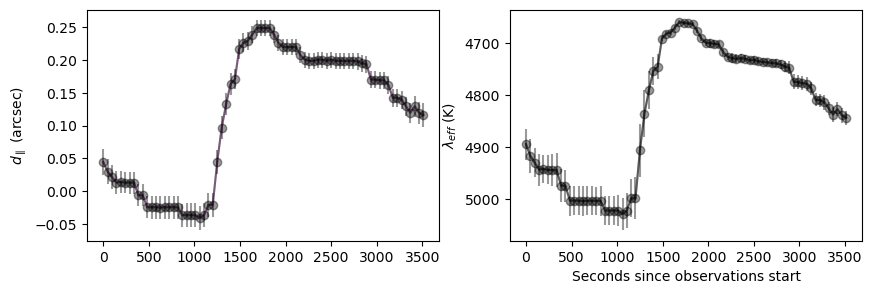

In [939]:
fig, axs = plt.subplots(1,2, figsize=(10,3))
#ax2 = ax1.twinx()
axs = axs.ravel()
axs[0].errorbar(tSec, dpar_smoothed, yerr = dparerr_smoothed, marker='o', color='k', alpha = 0.4, label= r'$\lambda_{eff}$')
axs[0].set_ylabel(r'$d_{\parallel}$ (arcsec)')

lns1 = axs[1].errorbar(tSec, flr_weffs, yerr = weffErrRadec, marker='o', color='k', alpha = 0.4, label= r'$\lambda_{eff}$')
axs[1].plot(tSec, flr_weffs, alpha=0.4, color='k')

ns3 = axs[0].plot(tSec, dpar_smoothed, color='purple', alpha=0.4, label=r'$d_{\parallel}$ (smoothed residual)')

axs[1].set_xlabel('Seconds since observations start')
axs[1].set_ylabel(r'$\lambda_{eff}$ (K)')
plt.gca().invert_yaxis()

fig.savefig('Figures/weffcurve.png', dpi=300, bbox_inches='tight')

In [940]:
#sets points within the flare in finds and outside in !finds
baseline_npoints = 700 #seconds since the start
baseline = np.nanmean(delta_g_mag[tSec - tSec[0] < baseline_npoints])
var = np.nanstd(delta_g_mag[tSec - tSec[0] < baseline_npoints])
finds = (delta_g_mag < baseline - 3 * var)
tflare0 = np.where(finds)[0][0] # index of the first flare point 
finds[tflare0:] = True
finds

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True])

### Scenario 1: Free FF, 2: Fixed FF, 3: FF rate change limited

In [941]:
def makemodel(tSec, delta_g_mag, flr_weffs, baseline_ff, weffErrRadec, delta_g_mag_err, lines=False, 
              rateCap=None, plot=True, contours=False):

    flr_teffs = []
    flr_ffs = []
    xinds2 = []
    yinds2 = []

    tPeak = np.where(abs(delta_g_mag) == np.nanmax(abs(delta_g_mag)))[0][0] #only apply rate cap on post-peak evolution
    
    linestag = "lines" if lines else "nolines"
    print(linestag)
    aInstance = 1e9
    nochange = 0
    for t, loopvars in enumerate(zip(flr_weffs, delta_g_mag, weffErrRadec, delta_g_mag_err)):
        weff, dmag, werr, dmagerr = loopvars
        if np.isnan(weff) | np.isnan(dmag): #skip missing data
            flr_teffs.append(np.nan)
            flr_ffs.append(np.nan)
            continue

        #Scale models and data to [0,1]
        model_weffs2 = weff_model[linestag].copy()
        model_mags2 = dmag_model[linestag].copy()
        
        """
        weff_norm=weff
        model_weffs2_norm=model_weffs2
        werr_norm=werr
        model_mags2_norm=model_mags2
        dmag_norm=dmag
        dmagerr_norm=dmagerr
        
        
        model_weffs2_norm = (model_weffs2 - model_weffs2.min()) / np.ptp(model_weffs2)
        weff_norm = (weff - model_weffs2.min()) / np.ptp(model_weffs2)
        werr_norm = (werr - model_weffs2.min()) / np.ptp(model_weffs2)

        model_mags2_norm = (model_mags2 - model_mags2.min()) / np.ptp(model_mags2)
        dmag_norm = (dmag - model_mags2.min()) /  np.ptp(model_mags2)
        dmagerr_norm = (dmagerr - model_mags2.min()) / np.ptp(model_mags2)
        
        """
        
        distances = np.sqrt((weff  - model_weffs2)**2 / werr*2 + 
                        (dmag - model_mags2)**2 / dmagerr**2)

        if contours:
            fig, axs = plt.subplots(1,1, figsize=(5,5))
            axs.imshow(distances, clim=(0,1)) 
            #plt.colorbar()
            X, Y = np.meshgrid(range(bins), range(bins))
            contours = axs.contour(X, Y, distances, 10, colors='black')
            axs.clabel(contours, inline=1, fontsize=10)
            plt.gca().invert_yaxis()
        
        if not rateCap is None:
            rc = rateCap * np.diff(tSec).mean() #convert rate cap to DWF cadence       
        
        walled_distances = distances.copy()
        if t < tflare0:
            #force filling factor to 0
            walls = np.where(a_grid != 0.0)[0]
            #print(walls)
            walled_distances[:, walls] = np.nan
        elif tflare0 <= t <= tPeak:
            nochange = 0
            #no constraints between the start and peak of the flare
            pass
        else:
            if rateCap is None:
                #to constraits to filling factor evolution
                walls = np.zeros(walled_distances.shape[1], bool)
            else:
                #limit the evolution of the filling factor post peak
                #### WARNING THIS IS WRONG
                walls = np.where((a_grid < aInstance - (aInstance * rc)) | (a_grid > aInstance + (aInstance * rc)))[0]
            walled_distances[:, walls] = np.nan
            
            
        mindex = list(np.where(walled_distances == np.nanmin(walled_distances)))
        
        minds = [ind[0] for ind in mindex]
        if a_grid[minds[1]] == aInstance:
            nochange += 1
        else:
            aInstance = a_grid[minds[1]]

        if contours:
            axs.plot(minds[1], minds[0], "*", ms=10, c="w")
            plt.show()
        
        xinds2.append(minds[1])
        yinds2.append(minds[0])
        flr_teffs.append(temp_grid[minds[0]])
        flr_ffs.append(a_grid[minds[1]])
    xinds2 = np.array(xinds2)
    yinds2 = np.array(yinds2)
        
    if plot:
     
        fig, ax = plt.subplots(1, 2, figsize=(10,6))
        fig.subplots_adjust(hspace = 15.5)
        
        tickstep = (bins - 1) // 10
        tickmax = (bins - 1) + tickstep
    
        im1 = ax[0].imshow(model_mags2, cmap='RdBu_r', origin='lower')
        cb1 = fig.colorbar(mappable=im1, fraction=0.05, orientation='horizontal')
        cb1.set_label(r'$\Delta m_g$', fontsize=12)
        cb1.ax.tick_params(labelsize=12)
        ax[0].set_yticks(ticks=np.arange(0, tickmax, tickstep), labels = np.array(temp_grid[::tickstep], dtype=int))
        ax[0].set_xticks(ticks=np.arange(0, tickmax, tickstep), labels = np.round(a_grid[::tickstep] * baseline_ff * 100, decimals=1))
        ax[0].set_xlabel('Filling Factor (%)', fontsize=12)
        ax[0].set_ylabel(r'$T_{BB}$ (K)', fontsize=12)
        ax[0].tick_params(axis='both', labelsize=12)
        
        im2 = ax[1].imshow(model_weffs2, cmap='RdBu_r', origin='lower')
        cb2 = fig.colorbar(mappable=im2, label=r'$\lambda_\mathrm{eff}$ ($\AA$)', fraction=0.05, orientation='horizontal')
        cb2.set_label(r'$\lambda_\mathrm{eff}$ $(\AA)$', fontsize=12)
        cb2.ax.tick_params(labelsize=12)
        ax[1].set_yticks(ticks=np.arange(0, tickmax, tickstep), labels = np.array(temp_grid[::tickstep], dtype=int))
        ax[1].set_xticks(ticks=np.arange(0, tickmax, tickstep), labels = np.round(a_grid[::tickstep] * baseline_ff * 100, decimals=1))
        ax[1].set_xlabel('Filling Factor (%)', fontsize=12)
        ax[1].set_ylabel(r'$T_{BB}$ (K)', fontsize=12)
        ax[1].tick_params(axis='both', labelsize=12)
        
        fig.suptitle(f'Model Grids with {"Lines" if lines else "No Lines"}', fontsize=14)
        fig.tight_layout()
        
        #fig.savefig('Figures/model_grids.png', dpi=300, bbox_inches='tight')
        
        ax[0].plot(xinds2, yinds2, c='grey', lw=1, ls='--', alpha=0.75)
        ax[0].scatter(xinds2[~finds], yinds2[~finds], c='k', s=100, facecolor='None')
        ax[0].scatter(xinds2[finds], yinds2[finds], c=np.linspace(0, 1, finds.sum()), cmap="bone", marker='.')
        ax[1].plot(xinds2, yinds2, c='grey', lw=1, ls='--', alpha=0.75)
        ax[1].scatter(xinds2[~finds], yinds2[~finds], c='k', s=100, facecolor='None')
        ax[1].scatter(xinds2[finds], yinds2[finds], c=np.linspace(0, 1, finds.sum()), cmap="bone", marker='.')

    flr_teffs2 = np.array(flr_teffs)
    flr_ffs2 = np.array(flr_ffs)
    #print(xinds2, yinds2)
    return flr_teffs2, flr_ffs2 * baseline_ff * 100, model_mags2, model_weffs2, yinds2, xinds2



In [942]:
def plotmodel(flr_teffs, flr_ffs, model_mags, model_weffs, yinds, xinds, title=None):
    fig, axes = plt.subplots(2,2, figsize=(10,6))
    ax = axes.flatten()

    ax[0].scatter(tSec[~finds], delta_g_mag[~finds], edgecolor='C0', facecolor='None', label='Quiescent')
    ax[0].scatter(tSec[finds], delta_g_mag[finds], c='C0', label='Flare')
    ax[0].hlines(np.nanmean(delta_g_mag[:np.where(tSec < baseline_npoints)[0][-1]]), 0, tSec[-1], color='C0', ls='--', 
                 label='Quiescent mean')
    ax[0].hlines(np.nanmean(delta_g_mag[:np.where(tSec < baseline_npoints)[0][-1]]) - 
             np.nanstd(delta_g_mag[:np.where(tSec < baseline_npoints)[0][-1]]) * 3, 0, tSec[-1], color='C0', ls=':', 
                 label=r'Quiescent mean +/- 3$\sigma$')
    ax[0].hlines(np.nanmean(delta_g_mag[:np.where(tSec < baseline_npoints)[0][-1]]) + 
             np.nanstd(delta_g_mag[:np.where(tSec < baseline_npoints)[0][-1]]) * 3, 0, tSec[-1], color='C0', ls=':')
    ax[0].plot(tSec, delta_g_mag, c='C0', alpha=0.4)
    ax[0].set_xlabel('Seconds since Observation Start')
    ax[0].set_ylabel(r'$\Delta m_g$')
    ax[0].set_ylim(ax[0].get_ylim()[::-1])
    ax[0].legend(loc='upper right', fontsize=8)

    ax[1].errorbar(tSec, dpar_smoothed, yerr = dparerr_smoothed, alpha=0.4, color='C1', ls='None')
    ax[1].scatter(tSec[~finds], dpar_smoothed[~finds], edgecolor='C1', facecolor='None')
    ax[1].scatter(tSec[finds], dpar_smoothed[finds], c='C1')
    ax[1].plot(tSec, dpar_smoothed, c='C1', alpha=0.4)
    ax[1].set_ylabel(r'$d_{\parallel}$ (arcsec)')
    ax[1].set_xlabel('Seconds since Observation Start')

    ax[2].scatter(tSec[~finds], flr_teffs["lines"][~finds], edgecolor='C2', facecolor='None')
    ax[2].scatter(tSec[finds], flr_teffs["lines"][finds], c='C2', label='lines')
    ax[2].scatter(tSec[~finds], flr_teffs["nolines"][~finds], edgecolor='grey', alpha=0.5, marker='d', facecolor='None')
    ax[2].scatter(tSec[finds], flr_teffs["nolines"][finds], c='grey', alpha=0.5, marker='d', label='no lines')
    ax[2].plot(tSec, flr_teffs["lines"], c='C2', ls='-', alpha=0.4)
    ax[2].plot(tSec, flr_teffs["nolines"], c='grey', ls='-', alpha=0.4)
    ax[2].set_xlabel('Seconds since Observation Start')
    ax[2].set_ylabel(r'$T_{eff}$ (K)')
    ax[2].legend()

    ax[3].scatter(tSec[~finds], flr_ffs["lines"][~finds], edgecolor='C3', facecolor='None')
    ax[3].scatter(tSec[finds], flr_ffs["lines"][finds], c='C3', label='lines')
    ax[3].scatter(tSec[~finds], flr_ffs["nolines"][~finds], edgecolor='grey', alpha=0.5, marker='d', facecolor='None')
    ax[3].scatter(tSec[finds], flr_ffs["nolines"][finds], c='grey', alpha=0.5, marker='d', label='no lines')
    ax[3].plot(tSec, flr_ffs["lines"], c='C3', alpha=0.4)
    ax[3].plot(tSec, flr_ffs["nolines"], c='grey', alpha=0.4, ls='-')
    ax[3].set_ylabel('Filling factor (%)')
    ax[3].set_xlabel('Seconds since Observation Start')
    ax[3].legend()

    xlim = ax[0].get_xlim()
    for a in ax:
        a.set_xlim(xlim)
    
    fig.suptitle(title)
    fig.tight_layout()

    fig, ax = plt.subplots(1, 2, figsize=(10,3))
    fig.subplots_adjust(hspace = 15.5)

    ax[0].errorbar(tSec - tSec[0], flr_weffs, yerr = weffErrRadec, alpha = 0.5, color='grey', marker='o', label='Original')
    ax[0].plot(tSec - tSec[0], model_weffs["lines"][yinds["lines"], xinds["lines"]], alpha= 1, label='Retrieved (lines)')
    ax[0].plot(tSec - tSec[0], model_weffs["nolines"][yinds["nolines"], xinds["nolines"]], alpha= 1, label='Retrieved (No lines)')
    ax[0].set_xlabel('Seconds since observation start')
    ax[0].set_ylabel(r'$\lambda_\mathrm{eff}$')
    ax[0].invert_yaxis()
    ax[0].legend(loc = 'lower right', fontsize=8)

    ax[1].errorbar(tSec - tSec[0], delta_g_mag, alpha = 0.5, c='grey', marker='o', label='Original')
    ax[1].plot(tSec - tSec[0], model_mags["lines"][yinds["lines"], xinds["lines"]], alpha= 1, label='Retrieved (lines)')
    ax[1].plot(tSec - tSec[0], model_mags["nolines"][yinds["nolines"], xinds["nolines"]], alpha= 1, label='Retrieved (No lines)')
    ax[1].set_xlabel('Seconds since observation start')
    ax[1].set_ylabel(r'$\Delta m_g$')
    ax[1].invert_yaxis()
    ax[1].legend(loc = 'lower right', fontsize=8)

    fig.suptitle(title)


## Scenario 1: No Constraints

In [943]:
flr_teffs = {"Scenario1":{}, "Scenario2":{}, "Scenario3":{}}
flr_ffs = {"Scenario1":{}, "Scenario2":{}, "Scenario3":{}}
model_mags = {"Scenario1":{}, "Scenario2":{}, "Scenario3":{}}
model_weffs = {"Scenario1":{}, "Scenario2":{}, "Scenario3":{}}
yinds = {"Scenario1":{}, "Scenario2":{}, "Scenario3":{}}
xinds = {"Scenario1":{}, "Scenario2":{}, "Scenario3":{}}


Saved with NO LINES
nolines
Saved with  LINES
lines


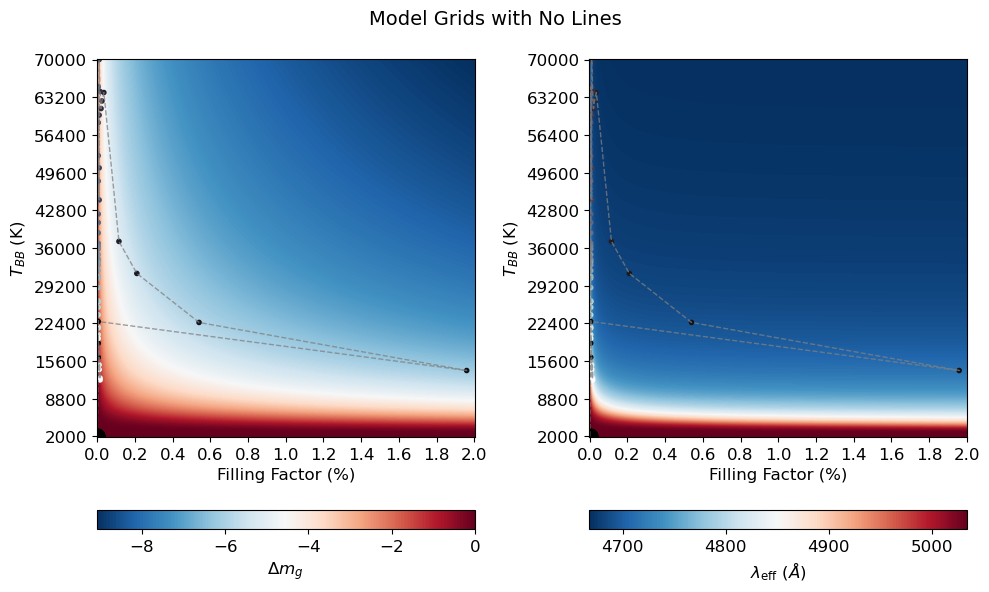

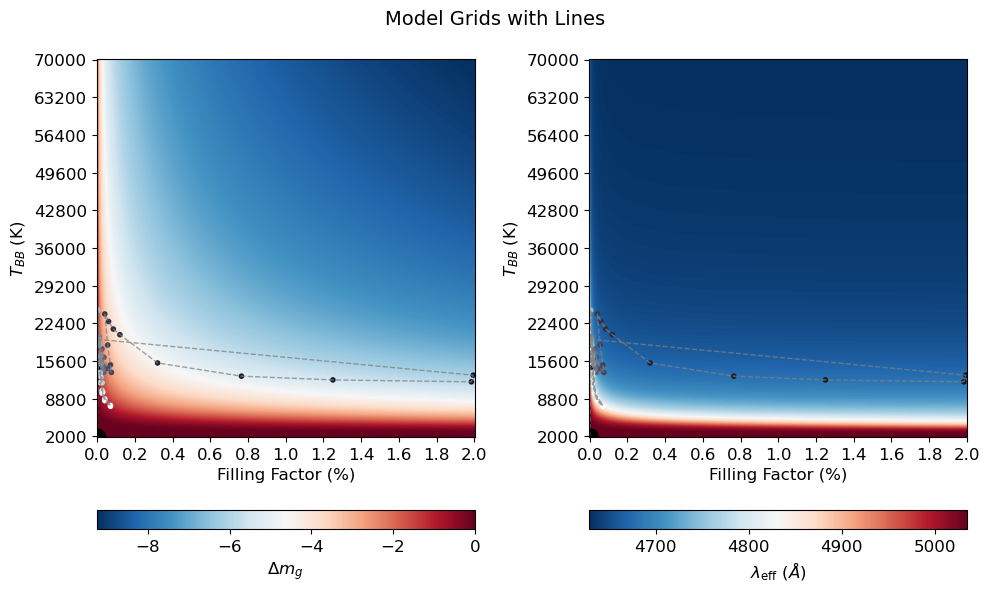

In [944]:
print("Saved with NO LINES")
    ##Model with no lines
flr_teffs["Scenario1"]["nolines"], flr_ffs["Scenario1"]["nolines"], model_mags["Scenario1"]["nolines"], model_weffs["Scenario1"]["nolines"], yinds["Scenario1"]["nolines"], xinds["Scenario1"]["nolines"] = makemodel(tSec, delta_g_mag, 
                                            flr_weffs, baseline_ff, weffErrRadec, delta_g_mag_err, lines=False, rateCap=None)

np.save('Outdata/flr_teffs1_nolines.npy', flr_teffs["Scenario1"]["nolines"])
np.save('Outdata/flr_ffs1_nolines.npy', flr_ffs["Scenario1"]["nolines"])
np.save('Outdata/retrived_mags1_nolines.npy', model_mags["Scenario1"]["nolines"][yinds["Scenario1"]["nolines"], xinds["Scenario1"]["nolines"]])
np.save('Outdata/retrived_weffs1_nolines.npy', model_weffs["Scenario1"]["nolines"][yinds["Scenario1"]["nolines"], xinds["Scenario1"]["nolines"]])

print("Saved with  LINES")
    ##Model with no lines
flr_teffs["Scenario1"]["lines"], flr_ffs["Scenario1"]["lines"], model_mags["Scenario1"]["lines"], model_weffs["Scenario1"]["lines"], yinds["Scenario1"]["lines"], xinds["Scenario1"]["lines"] = makemodel(tSec, delta_g_mag, 
                                            flr_weffs, baseline_ff, weffErrRadec, delta_g_mag_err, lines=True, rateCap=None)

np.save('Outdata/flr_teffs1_lines.npy', flr_teffs["Scenario1"]["lines"])
np.save('Outdata/flr_ffs1_lines.npy', flr_ffs["Scenario1"]["lines"])
np.save('Outdata/retrived_mags1_lines.npy', model_mags["Scenario1"]["lines"][yinds["Scenario1"]["lines"], xinds["Scenario1"]["lines"]])
np.save('Outdata/retrived_weffs1_lines.npy', model_weffs["Scenario1"]["lines"][yinds["Scenario1"]["lines"], xinds["Scenario1"]["lines"]])


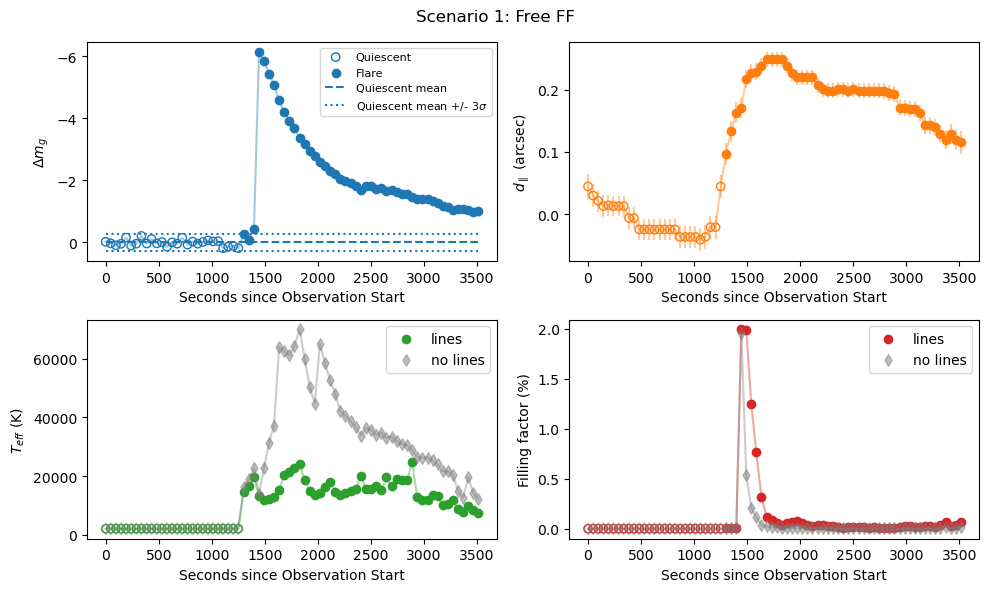

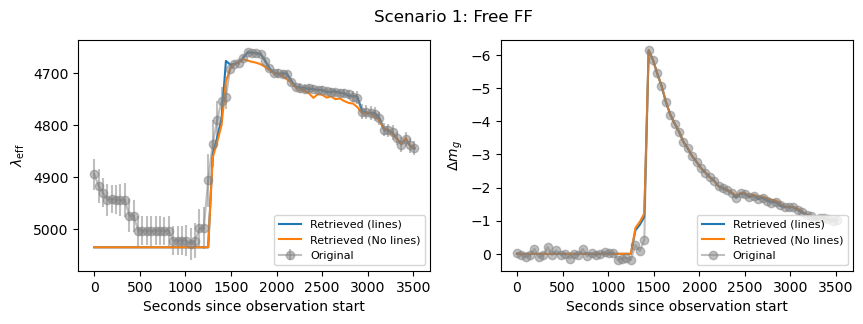

In [945]:
plotmodel(flr_teffs["Scenario1"], flr_ffs["Scenario1"], model_mags["Scenario1"], model_weffs["Scenario1"], 
          yinds["Scenario1"], xinds["Scenario1"], title="Scenario 1: Free FF")

## Scenarion 2: Fixed FF

Saved with NO LINES
nolines
Saved with  LINES
lines


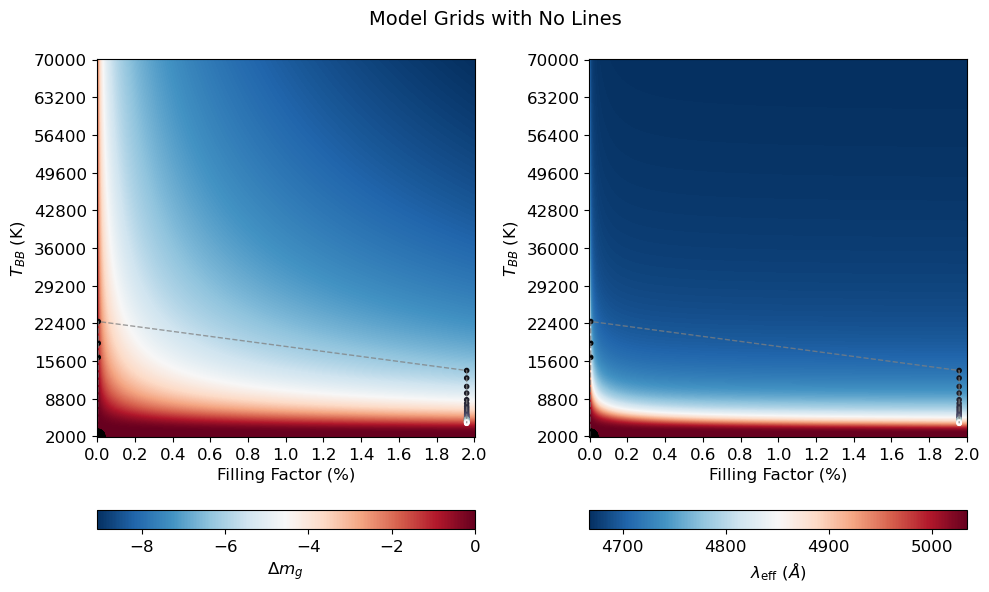

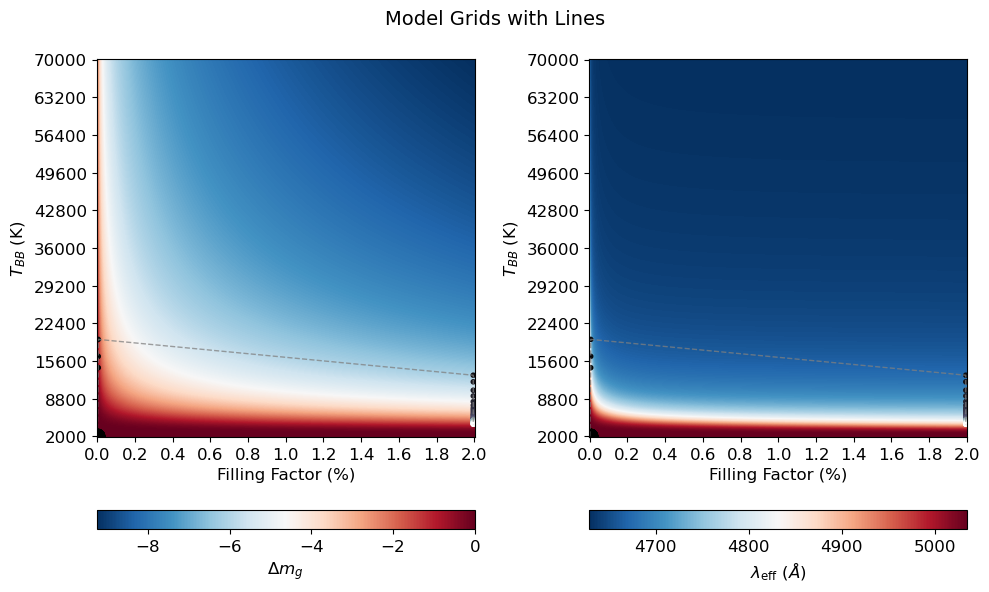

In [946]:
print("Saved with NO LINES")
    ##Model with no lines
flr_teffs["Scenario2"]["nolines"], flr_ffs["Scenario2"]["nolines"], model_mags["Scenario2"]["nolines"], model_weffs["Scenario2"]["nolines"], yinds["Scenario2"]["nolines"], xinds["Scenario2"]["nolines"] = makemodel(tSec, delta_g_mag, 
                                            flr_weffs, baseline_ff, weffErrRadec, delta_g_mag_err, lines=False, rateCap=0)

np.save('Outdata/flr_teffs2_nolines.npy', flr_teffs["Scenario2"]["nolines"])
np.save('Outdata/flr_ffs2_nolines.npy', flr_ffs["Scenario2"]["nolines"])
np.save('Outdata/retrived_mags2_nolines.npy', model_mags["Scenario2"]["nolines"][yinds["Scenario2"]["nolines"], xinds["Scenario2"]["nolines"]])
np.save('Outdata/retrived_weffs2_nolines.npy', model_weffs["Scenario2"]["nolines"][yinds["Scenario2"]["nolines"], xinds["Scenario2"]["nolines"]])

print("Saved with  LINES")
    ##Model with no lines
flr_teffs["Scenario2"]["lines"], flr_ffs["Scenario2"]["lines"], model_mags["Scenario2"]["lines"], model_weffs["Scenario2"]["lines"], yinds["Scenario2"]["lines"], xinds["Scenario2"]["lines"] = makemodel(tSec, delta_g_mag, 
                                            flr_weffs, baseline_ff, weffErrRadec, delta_g_mag_err, lines=True, rateCap=0)

np.save('Outdata/flr_teffs2_lines.npy', flr_teffs["Scenario2"]["lines"])
np.save('Outdata/flr_ffs2_lines.npy', flr_ffs["Scenario2"]["lines"])
np.save('Outdata/retrived_mags2_lines.npy', model_mags["Scenario2"]["lines"][yinds["Scenario2"]["lines"], xinds["Scenario2"]["lines"]])
np.save('Outdata/retrived_weffs2_lines.npy', model_weffs["Scenario2"]["lines"][yinds["Scenario2"]["lines"], xinds["Scenario2"]["lines"]])



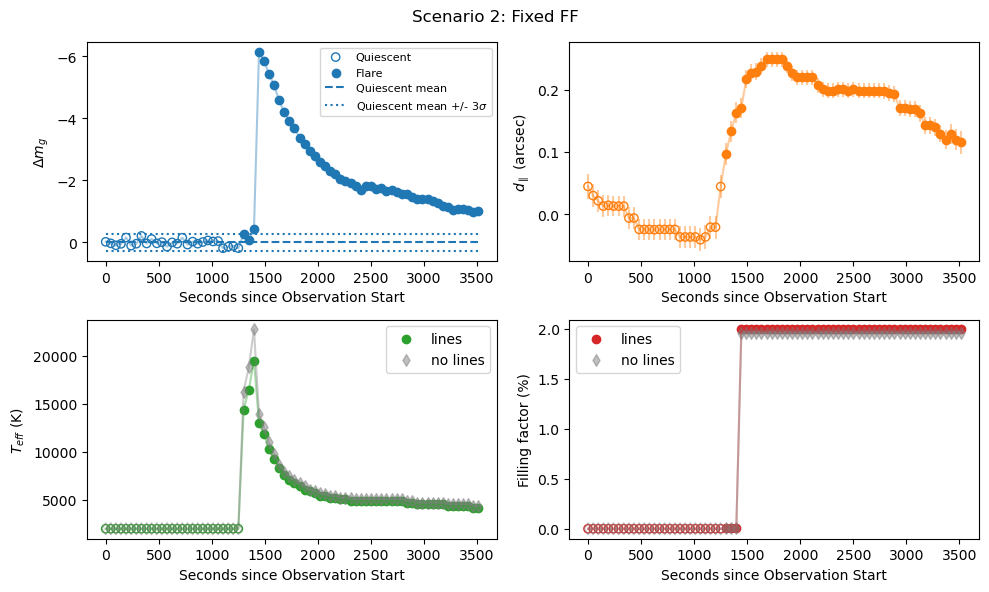

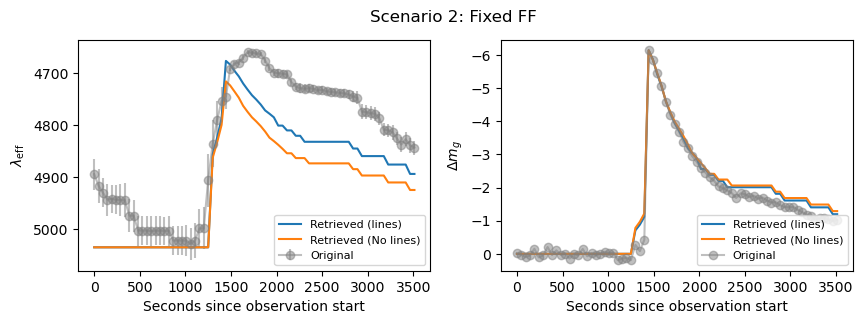

In [947]:
plotmodel(flr_teffs["Scenario2"], flr_ffs["Scenario2"], model_mags["Scenario2"], model_weffs["Scenario2"], 
          yinds["Scenario2"], xinds["Scenario2"], title="Scenario 2: Fixed FF")

## Scenario 3: Controlled FF

Saved with NO LINES
nolines
Saved with  LINES
lines


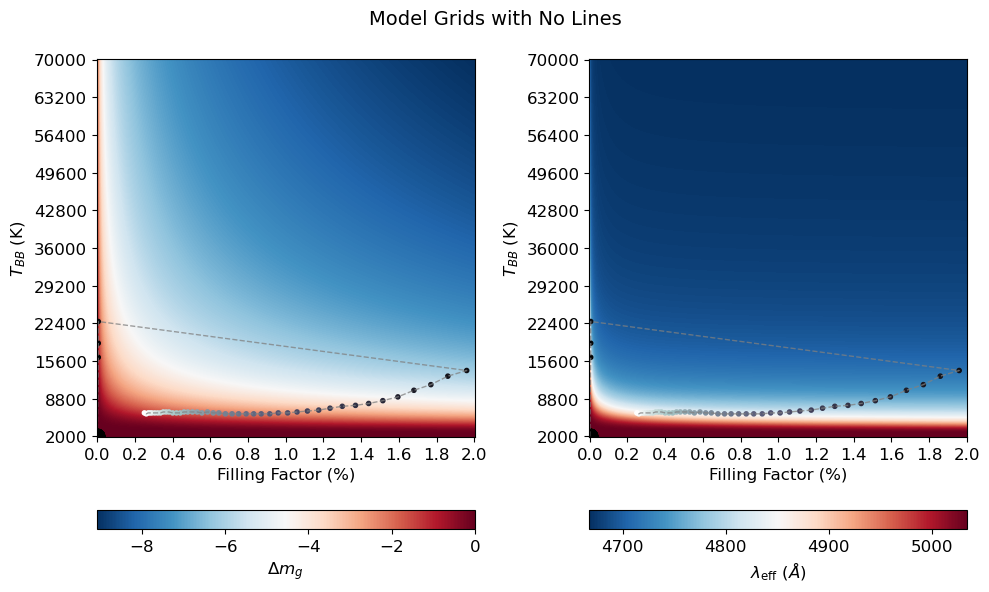

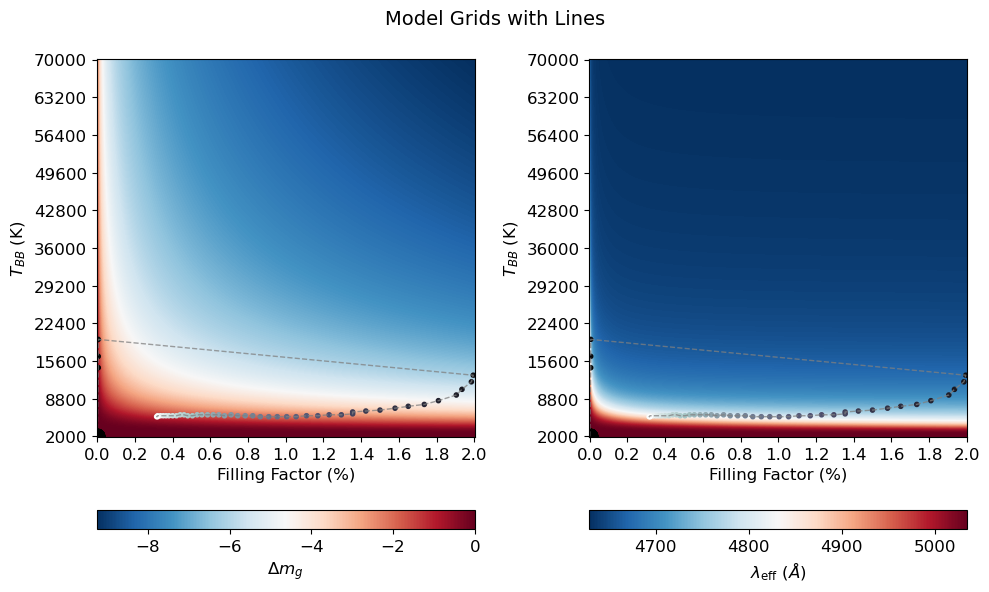

In [948]:
print("Saved with NO LINES")
    ##Model with no lines
flr_teffs["Scenario3"]["nolines"], flr_ffs["Scenario3"]["nolines"], model_mags["Scenario3"]["nolines"], model_weffs["Scenario3"]["nolines"], yinds["Scenario3"]["nolines"], xinds["Scenario3"]["nolines"] = makemodel(tSec, delta_g_mag, 
                                            flr_weffs, baseline_ff, weffErrRadec, delta_g_mag_err, lines=False, rateCap=globals.rateCap)

np.save('Outdata/flr_teffs3_nolines.npy', flr_teffs["Scenario3"]["nolines"])
np.save('Outdata/flr_ffs3_nolines.npy', flr_ffs["Scenario3"]["nolines"])
np.save('Outdata/retrived_mags3_nolines.npy', model_mags["Scenario3"]["nolines"][yinds["Scenario3"]["nolines"], xinds["Scenario3"]["nolines"]])
np.save('Outdata/retrived_weffs3_nolines.npy', model_weffs["Scenario3"]["nolines"][yinds["Scenario3"]["nolines"], xinds["Scenario3"]["nolines"]])

print("Saved with  LINES")
    ##Model with no lines
flr_teffs["Scenario3"]["lines"], flr_ffs["Scenario3"]["lines"], model_mags["Scenario3"]["lines"], model_weffs["Scenario3"]["lines"], yinds["Scenario3"]["lines"], xinds["Scenario3"]["lines"] = makemodel(tSec, delta_g_mag, 
                                            flr_weffs, baseline_ff, weffErrRadec, delta_g_mag_err, lines=True, rateCap=globals.rateCap)

np.save('Outdata/flr_teffs3_lines.npy', flr_teffs["Scenario3"]["lines"])
np.save('Outdata/flr_ffs3_lines.npy', flr_ffs["Scenario3"]["lines"])
np.save('Outdata/retrived_mags3_lines.npy', model_mags["Scenario3"]["lines"][yinds["Scenario3"]["lines"], xinds["Scenario3"]["lines"]])
np.save('Outdata/retrived_weffs3_lines.npy', model_weffs["Scenario3"]["lines"][yinds["Scenario3"]["lines"], xinds["Scenario3"]["lines"]])



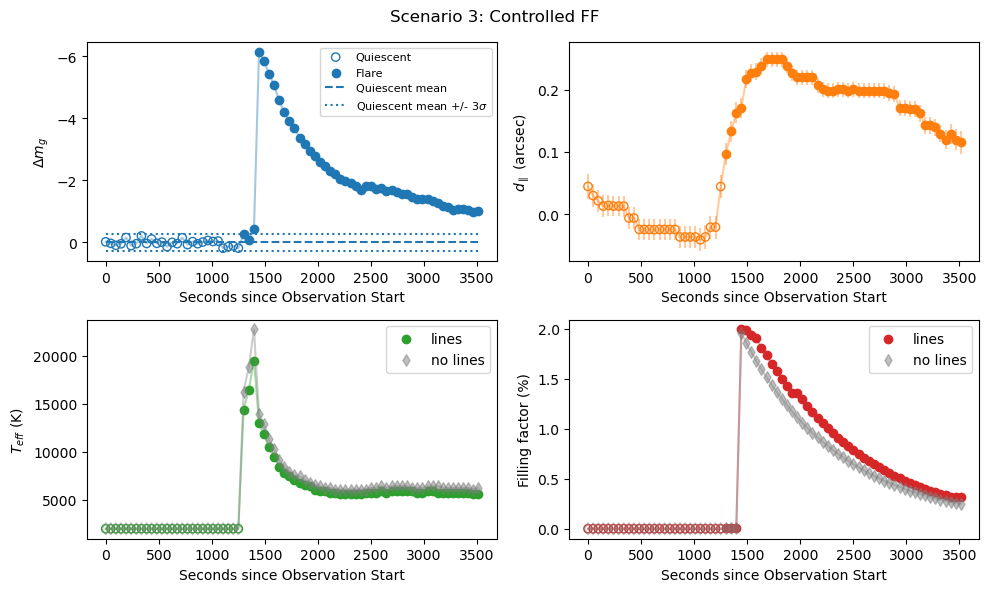

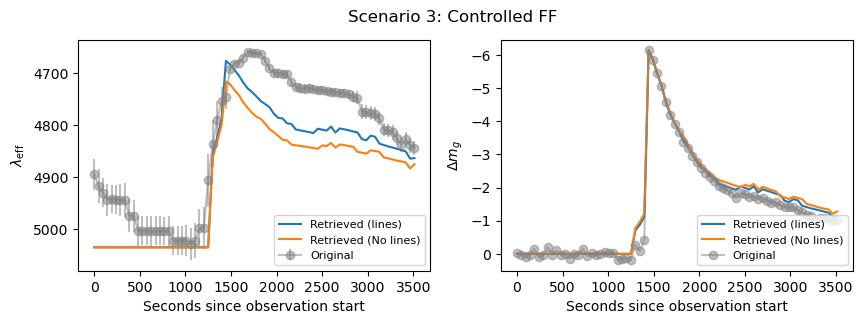

In [949]:
plotmodel(flr_teffs["Scenario3"], flr_ffs["Scenario3"], model_mags["Scenario3"], model_weffs["Scenario3"], 
          yinds["Scenario3"], xinds["Scenario3"], title="Scenario 3: Controlled FF")

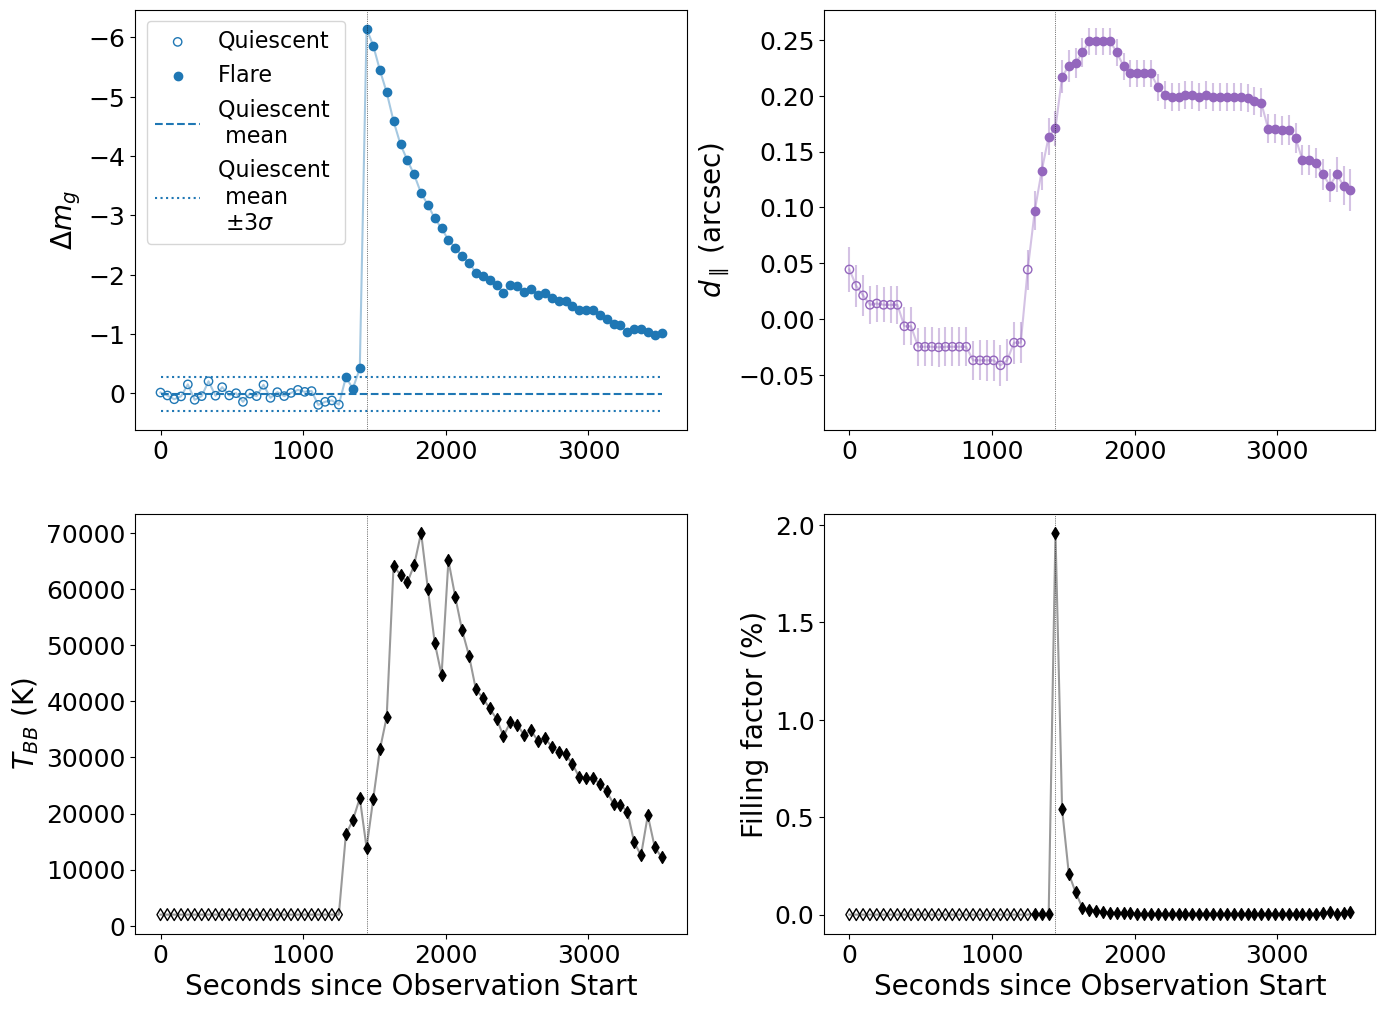

In [958]:
fig, axes = plt.subplots(2,2,figsize=(16,12))
fig.subplots_adjust(wspace=0.25)
ax = axes.flatten()
#~finds = np.arange(0,30)
#finds = np.arange(30,74)

ax[0].scatter(tSec[~finds], delta_g_mag[~finds], edgecolor='C0', facecolor='None', label='Quiescent')
ax[0].scatter(tSec[finds], delta_g_mag[finds], c='C0', label='Flare')
ax[0].hlines(np.nanmean(delta_g_mag[:np.where(tSec < baseline_npoints)[0][-1]]), 0, tSec[-1], color='C0', ls='--', 
             label='Quiescent \n mean')
ax[0].hlines(np.nanmean(delta_g_mag[:np.where(tSec < baseline_npoints)[0][-1]]) - 
             np.nanstd(delta_g_mag[:np.where(tSec < baseline_npoints)[0][-1]]) * 3, 0, tSec[-1], color='C0', ls=':', 
             label='Quiescent \n mean \n '+r'$\pm$'+r'3$\sigma$')
ax[0].hlines(np.nanmean(delta_g_mag[:np.where(tSec < baseline_npoints)[0][-1]]) + 
             np.nanstd(delta_g_mag[:np.where(tSec < baseline_npoints)[0][-1]]) * 3, 0, tSec[-1], color='C0', ls=':')
ax[0].plot(tSec, delta_g_mag, c='C0', alpha=0.4)
ax[0].set_ylabel(r'$\Delta m_g$')
ax[0].set_ylim(ax[0].get_ylim()[::-1])
ax[0].axvline(x=tSec[tPeak], lw=0.5, ls = 'dotted', c='k')
ax[0].legend(loc='upper left', fontsize=16)

ax[1].errorbar(tSec, dpar_smoothed, yerr = dparerr_smoothed, alpha=0.4, color='C4', ls='None')
ax[1].scatter(tSec[~finds], dpar_smoothed[~finds], edgecolor='C4', facecolor='None')
ax[1].scatter(tSec[finds], dpar_smoothed[finds], c='C4')
ax[1].plot(tSec, dpar_smoothed, c='C4', alpha=0.4)
ax[1].axvline(x=tSec[tPeak], lw=0.5, ls = 'dotted', c='k')

ax[1].set_ylim(-0.099, None)
ax[1].set_ylabel(r'$d_{\parallel}$ (arcsec)')


ax[2].scatter(tSec[~finds], np.load('Outdata/flr_teffs1_nolines.npy')[~finds], edgecolor='k', marker='d', facecolor='None')
ax[2].scatter(tSec[finds], np.load('Outdata/flr_teffs1_nolines.npy')[finds], c='k', marker='d')
ax[2].plot(tSec, np.load('Outdata/flr_teffs1_nolines.npy'), c='k', alpha=0.4, ls='-')
ax[2].axvline(x=tSec[tPeak], lw=0.5, ls = 'dotted', c='k')

ax[2].set_xlabel('Seconds since Observation Start')
ax[2].set_ylabel(r'$T_{BB}$ (K)')

ax[3].axvline(x=tSec[tPeak], lw=0.5, ls = 'dotted', c='k')

ax[3].scatter(tSec[~finds], np.load('Outdata/flr_ffs1_nolines.npy')[~finds], edgecolor='k', marker='d', facecolor='None')
ax[3].scatter(tSec[finds], np.load('Outdata/flr_ffs1_nolines.npy')[finds], c='k', marker='d')
ax[3].plot(tSec, np.load('Outdata/flr_ffs1_nolines.npy'), c='k', alpha=0.4, ls='-')
ax[3].set_ylabel('Filling factor (%)')
ax[3].set_xlabel('Seconds since Observation Start')

for i, a in enumerate(ax):
    a.tick_params(axis='both', labelsize=18)
    a.xaxis.get_label().set_fontsize(20)
    a.yaxis.get_label().set_fontsize(20)

fig.savefig('Figures/result_grid_partial.png', bbox_inches='tight')

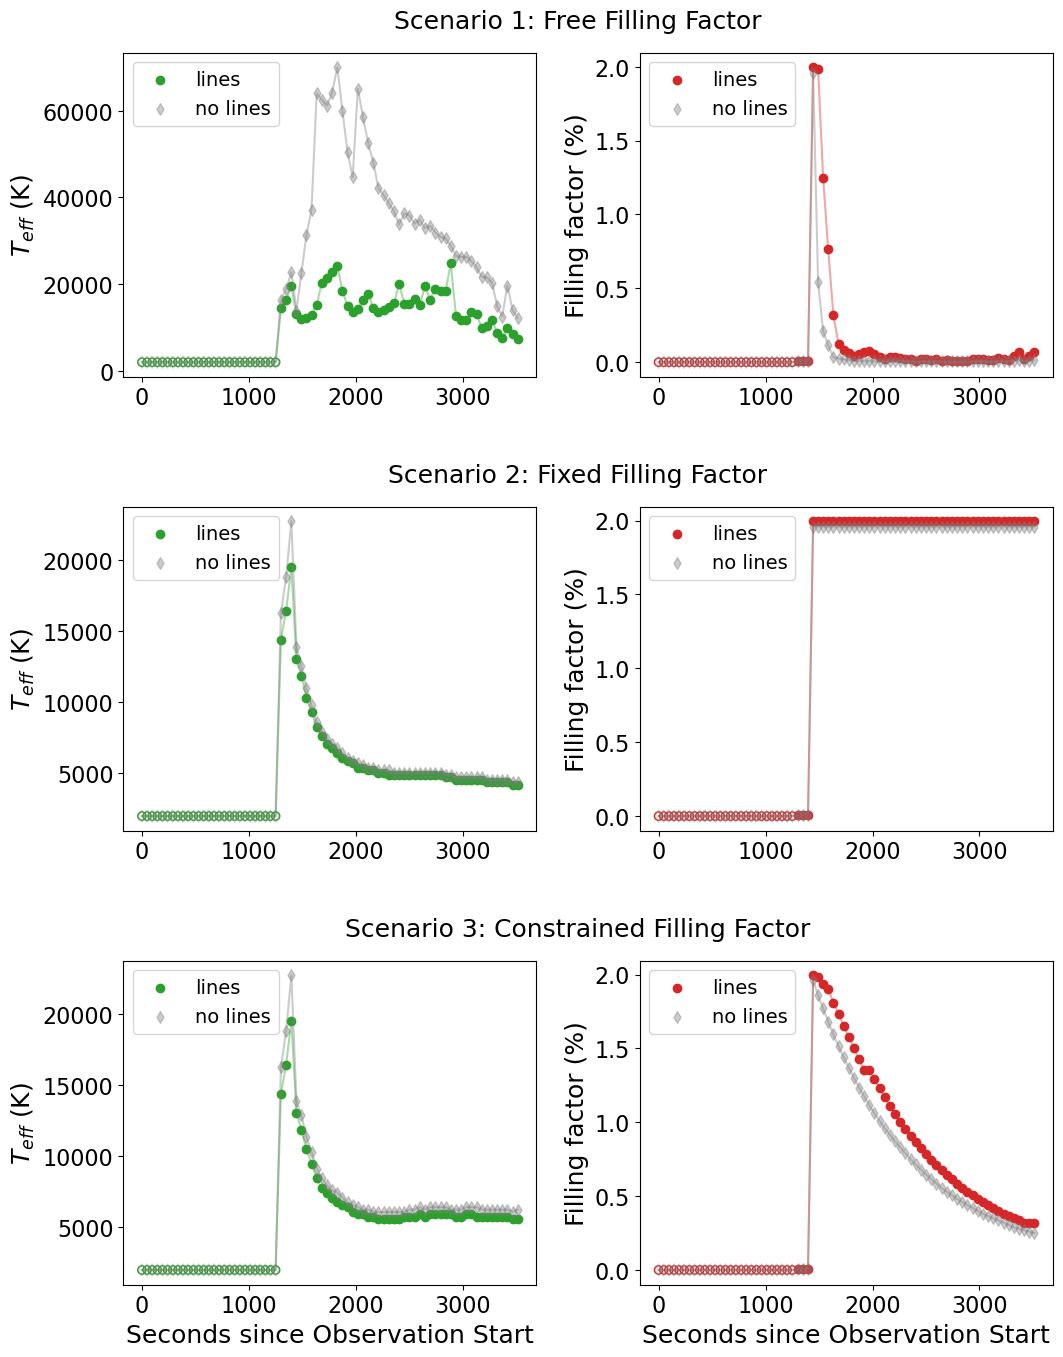

In [959]:
fig, axes = plt.subplots(3,2,figsize=(12,16))
fig.subplots_adjust(hspace=0.4, wspace=0.25)
ax = axes.flatten()
#~finds = np.arange(0,30)
#finds = np.arange(30,74)


ax[0].scatter(tSec[~finds], np.load('Outdata/flr_teffs1_lines.npy')[~finds], edgecolor='C2', facecolor='None')
ax[0].scatter(tSec[finds], np.load('Outdata/flr_teffs1_lines.npy')[finds], c='C2', label='lines')
ax[0].scatter(tSec[~finds], np.load('Outdata/flr_teffs1_nolines.npy')[~finds], edgecolor='grey', alpha=0.4, marker='d', facecolor='None')
ax[0].scatter(tSec[finds], np.load('Outdata/flr_teffs1_nolines.npy')[finds], c='grey', alpha=0.4, marker='d', label='no lines')
ax[0].plot(tSec, np.load('Outdata/flr_teffs1_lines.npy'), c='C2', alpha=0.4)
ax[0].plot(tSec, np.load('Outdata/flr_teffs1_nolines.npy'), c='grey', ls='-', alpha=0.4)
ax[0].set_ylabel(r'$T_{eff}$ (K)')
ax[0].legend()

ax[1].scatter(tSec[~finds], np.load('Outdata/flr_ffs1_lines.npy')[~finds], edgecolor='C3', facecolor='None')
ax[1].scatter(tSec[finds], np.load('Outdata/flr_ffs1_lines.npy')[finds], c='C3', label='lines')
ax[1].scatter(tSec[~finds], np.load('Outdata/flr_ffs1_nolines.npy')[~finds], edgecolor='grey', alpha=0.4, marker='d', facecolor='None')
ax[1].scatter(tSec[finds], np.load('Outdata/flr_ffs1_nolines.npy')[finds], c='grey', alpha=0.4, marker='d', label='no lines')
ax[1].plot(tSec, np.load('Outdata/flr_ffs1_lines.npy'), c='C3', alpha=0.4)
ax[1].plot(tSec, np.load('Outdata/flr_ffs1_nolines.npy'), c='grey', alpha=0.4, ls='-')
ax[1].set_ylabel('Filling factor (%)')
ax[1].legend()

ax[2].scatter(tSec[~finds], np.load('Outdata/flr_teffs2_lines.npy')[~finds], edgecolor='C2', facecolor='None')
ax[2].scatter(tSec[finds], np.load('Outdata/flr_teffs2_lines.npy')[finds], c='C2', label='lines')
ax[2].scatter(tSec[~finds], np.load('Outdata/flr_teffs2_nolines.npy')[~finds], edgecolor='grey', alpha=0.4, marker='d', facecolor='None')
ax[2].scatter(tSec[finds], np.load('Outdata/flr_teffs2_nolines.npy')[finds], c='grey', alpha=0.4, marker='d', label='no lines')
ax[2].plot(tSec, np.load('Outdata/flr_teffs2_lines.npy'), c='C2', alpha=0.4)
ax[2].plot(tSec, np.load('Outdata/flr_teffs2_nolines.npy'), c='grey', ls='-', alpha=0.4)
ax[2].set_ylabel(r'$T_{eff}$ (K)')
ax[2].legend()

ax[3].scatter(tSec[~finds], np.load('Outdata/flr_ffs2_lines.npy')[~finds], edgecolor='C3', facecolor='None')
ax[3].scatter(tSec[finds], np.load('Outdata/flr_ffs2_lines.npy')[finds], c='C3', label='lines')
ax[3].scatter(tSec[~finds], np.load('Outdata/flr_ffs2_nolines.npy')[~finds], edgecolor='grey', alpha=0.4, marker='d', facecolor='None')
ax[3].scatter(tSec[finds], np.load('Outdata/flr_ffs2_nolines.npy')[finds], c='grey', alpha=0.4, marker='d', label='no lines')
ax[3].plot(tSec, np.load('Outdata/flr_ffs2_lines.npy'), c='C3', alpha=0.4)
ax[3].plot(tSec, np.load('Outdata/flr_ffs2_nolines.npy'), c='grey', alpha=0.4, ls='-')
ax[3].set_ylabel('Filling factor (%)')
ax[3].legend()

ax[4].scatter(tSec[~finds], np.load('Outdata/flr_teffs3_lines.npy')[~finds], edgecolor='C2', facecolor='None')
ax[4].scatter(tSec[finds], np.load('Outdata/flr_teffs3_lines.npy')[finds], c='C2', label='lines')
ax[4].scatter(tSec[~finds], np.load('Outdata/flr_teffs3_nolines.npy')[~finds], edgecolor='grey', alpha=0.4, marker='d', facecolor='None')
ax[4].scatter(tSec[finds], np.load('Outdata/flr_teffs3_nolines.npy')[finds], c='grey', alpha=0.4, marker='d', label='no lines')
ax[4].plot(tSec, np.load('Outdata/flr_teffs3_lines.npy'), c='C2', alpha=0.4)
ax[4].plot(tSec, np.load('Outdata/flr_teffs3_nolines.npy'), c='grey', ls='-', alpha=0.4)
ax[4].set_xlabel('Seconds since Observation Start')
ax[4].set_ylabel(r'$T_{eff}$ (K)')
ax[4].legend()

ax[5].scatter(tSec[~finds], np.load('Outdata/flr_ffs3_lines.npy')[~finds], edgecolor='C3', facecolor='None')
ax[5].scatter(tSec[finds], np.load('Outdata/flr_ffs3_lines.npy')[finds], c='C3', label='lines')
ax[5].scatter(tSec[~finds], np.load('Outdata/flr_ffs3_nolines.npy')[~finds], edgecolor='grey', alpha=0.4, marker='d', facecolor='None')
ax[5].scatter(tSec[finds], np.load('Outdata/flr_ffs3_nolines.npy')[finds], c='grey', alpha=0.4, marker='d', label='no lines')
ax[5].plot(tSec, np.load('Outdata/flr_ffs3_lines.npy'), c='C3', alpha=0.4)
ax[5].plot(tSec, np.load('Outdata/flr_ffs3_nolines.npy'), c='grey', alpha=0.4, ls='-')
ax[5].set_ylabel('Filling factor (%)')
ax[5].set_xlabel('Seconds since Observation Start')
ax[5].legend()

for i, a in enumerate(ax):
    a.tick_params(axis='both', labelsize=16)
    a.xaxis.get_label().set_fontsize(18)
    a.yaxis.get_label().set_fontsize(18)
    a.legend(loc='upper left', fontsize=14)

ax[0].set_title('Scenario 1: Free Filling Factor', x=1.1, y=1.05, fontsize=18)
ax[2].set_title('Scenario 2: Fixed Filling Factor', x=1.1, y=1.05, fontsize=18)
ax[4].set_title('Scenario 3: Constrained Filling Factor', x=1.1, y=1.05, fontsize=18)

fig.savefig('Figures/result_grid_full.png', bbox_inches='tight')

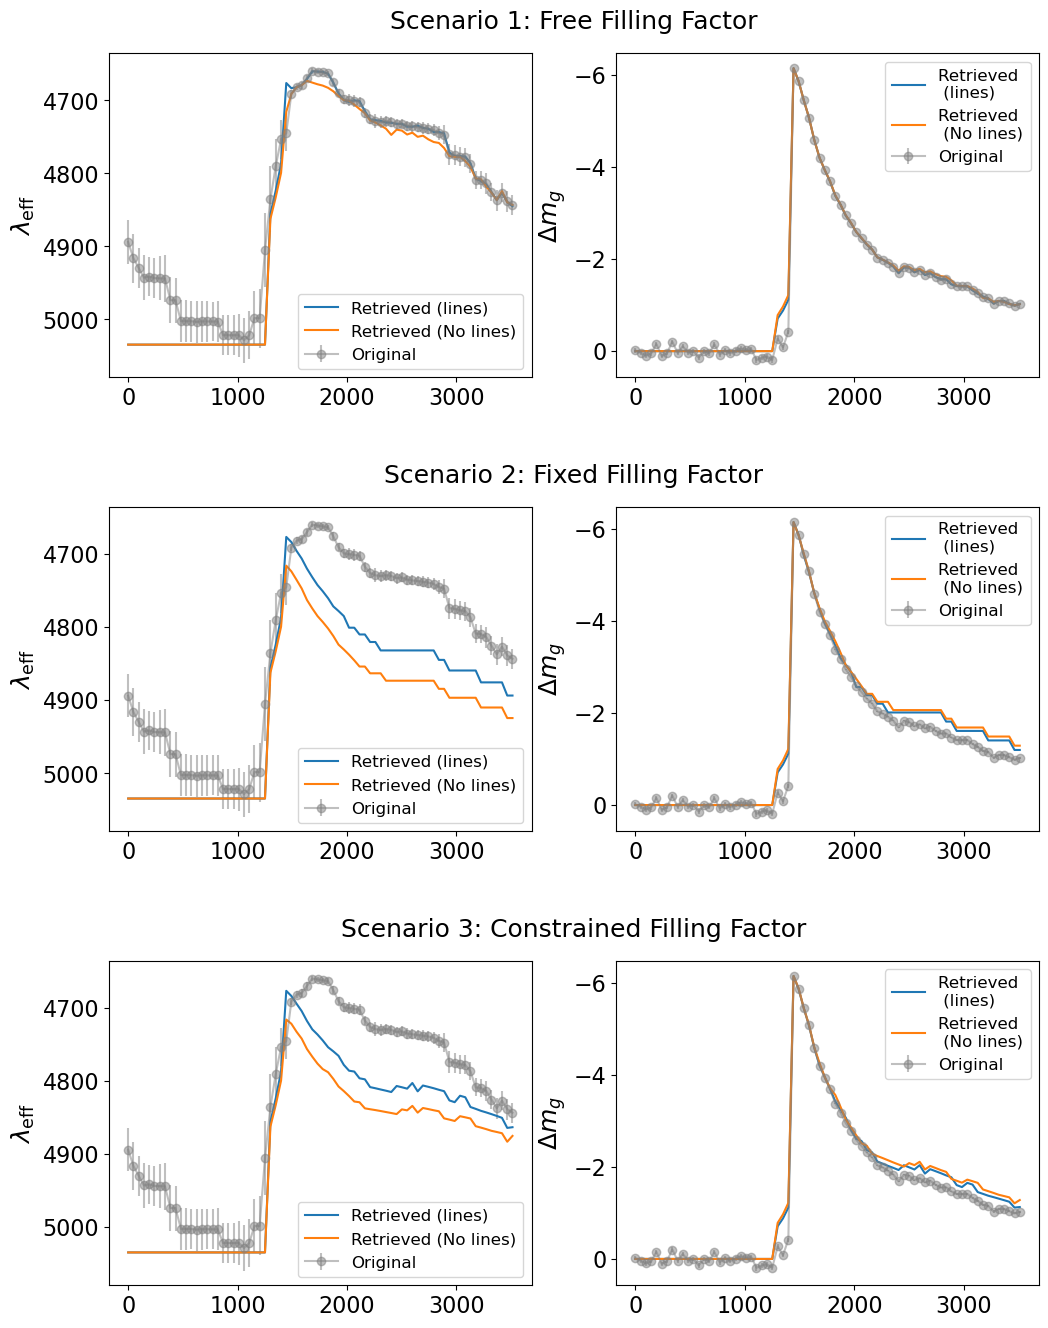

In [960]:
fig, axes = plt.subplots(3,2,figsize=(12,16))
fig.subplots_adjust(hspace=0.4)
ax = axes.flatten()
#~finds = np.arange(0,30)
#finds = np.arange(30,74)

ax[0].errorbar(tSec, flr_weffs, yerr = weffErrRadec, alpha = 0.5, c='grey', marker='o', label='Original')
ax[0].plot(tSec, np.load('Outdata/retrived_weffs1_lines.npy'), label='Retrieved (lines)')
ax[0].plot(tSec, np.load('Outdata/retrived_weffs1_nolines.npy'), label='Retrieved (No lines)')
ax[0].set_ylabel(r'$\lambda_\mathrm{eff}$')
ax[0].invert_yaxis()
ax[0].legend(loc = 'lower right', fontsize=8)

ax[1].plot(tSec, np.load('Outdata/retrived_mags1_lines.npy'), label='Retrieved \n (lines)')
ax[1].plot(tSec, np.load('Outdata/retrived_mags1_nolines.npy'), label='Retrieved \n (No lines)')
ax[1].errorbar(tSec, delta_g_mag, yerr=delta_g_mag_err, alpha = 0.5, c='grey', marker='o', label='Original')
ax[1].set_ylabel(r'$\Delta m_g$')
ax[1].invert_yaxis()
ax[1].legend(loc = 'lower right', fontsize=8)

ax[2].errorbar(tSec, flr_weffs, yerr = weffErrRadec, alpha = 0.5, c='grey', marker='o', label='Original')
ax[2].plot(tSec, np.load('Outdata/retrived_weffs2_lines.npy'), label='Retrieved (lines)')
ax[2].plot(tSec, np.load('Outdata/retrived_weffs2_nolines.npy'), label='Retrieved (No lines)')
ax[2].set_ylabel(r'$\lambda_\mathrm{eff}$')
ax[2].invert_yaxis()
ax[2].legend(loc = 'lower right', fontsize=8)

ax[3].errorbar(tSec, delta_g_mag, yerr=delta_g_mag_err, alpha = 0.5, c='grey', marker='o', label='Original')
ax[3].plot(tSec, np.load('Outdata/retrived_mags2_lines.npy'), label='Retrieved \n (lines)')
ax[3].plot(tSec, np.load('Outdata/retrived_mags2_nolines.npy'), label='Retrieved \n (No lines)')
ax[3].set_ylabel(r'$\Delta m_g$')
ax[3].invert_yaxis()
ax[3].legend(loc = 'lower right', fontsize=8)

ax[4].errorbar(tSec, flr_weffs, yerr = weffErrRadec, alpha = 0.5, c='grey', marker='o', label='Original')
ax[4].plot(tSec, np.load('Outdata/retrived_weffs3_lines.npy'), label='Retrieved (lines)')
ax[4].plot(tSec, np.load('Outdata/retrived_weffs3_nolines.npy'), label='Retrieved (No lines)')
ax[4].set_ylabel(r'$\lambda_\mathrm{eff}$')
ax[4].invert_yaxis()
ax[4].legend(loc = 'lower right', fontsize=8)

ax[5].errorbar(tSec, delta_g_mag, yerr=delta_g_mag_err, c='grey', alpha = 0.5, marker='o', label='Original')
ax[5].plot(tSec, np.load('Outdata/retrived_mags3_lines.npy'), label='Retrieved \n (lines)')
ax[5].plot(tSec, np.load('Outdata/retrived_mags3_nolines.npy'), label='Retrieved \n (No lines)')
ax[5].set_ylabel(r'$\Delta m_g$')
ax[5].invert_yaxis()
ax[5].legend(loc = 'lower right', fontsize=8)

ax[0].set_title('Scenario 1: Free Filling Factor', x=1.1, y=1.05, fontsize=18)
ax[2].set_title('Scenario 2: Fixed Filling Factor', x=1.1, y=1.05, fontsize=18)
ax[4].set_title('Scenario 3: Constrained Filling Factor', x=1.1, y=1.05, fontsize=18)

for i, a in enumerate(ax):
    a.tick_params(axis='both', labelsize=16)
    a.xaxis.get_label().set_fontsize(18)
    a.yaxis.get_label().set_fontsize(18)

    if i % 2 == 0:
        a.legend(loc = 'lower right', fontsize=12)
    else:
        a.legend(loc = 'upper right', fontsize=12)

fig.savefig('Figures/retrieval.png', dpi=300, bbox_inches='tight')

In [961]:
print("Flare reaches peak mag at ", (times[np.where(delta_g_mag == np.nanmin(delta_g_mag))[0][0]] - times[0]) * DAY2SEC, "s")

Flare reaches peak mag at  1444.8502480750903 s


In [962]:
print("Flare reaches peak temp at ", (times[np.where(flr_teffs3 == np.nanmax(flr_teffs3))[0][0]] - times[0]) * DAY2SEC, "s")

Flare reaches peak temp at  0.0 s


In [963]:
print("Peak temp = {}".format(np.nanmax(flr_teffs3)))

Peak temp = {'nolines': array([2800., 2800., 2800., 2800., 2800., 2800., 2800., 2800., 2800.,
       2800., 2800., 2800., 2800., 2800., 2800., 2800., 2800., 2800.,
       2800., 2800., 2800., 2800., 2800., 2800., 2800., 2800., 2800.,
       3350., 3350., 3900., 8300., 8300., 8300., 8300., 8300., 8300.,
       8300., 8300., 7200., 7200., 6650., 6650., 6100., 6100., 6100.,
       5550., 5550., 5550., 5550., 5550., 5000., 5550., 5550., 5000.,
       5550., 5000., 5000., 5000., 5000., 5000., 5000., 5000., 5000.,
       5000., 5000., 5000., 4450., 4450., 4450., 4450., 4450., 4450.,
       4450., 4450.]), 'lines': array([2800., 2800., 2800., 2800., 2800., 2800., 2800., 2800., 2800.,
       2800., 2800., 2800., 2800., 2800., 2800., 2800., 2800., 2800.,
       2800., 2800., 2800., 2800., 2800., 2800., 2800., 2800., 2800.,
       3350., 3350., 3900., 8300., 8300., 8300., 8300., 8300., 8300.,
       8300., 7750., 7200., 6650., 6650., 6100., 6100., 6100., 5550.,
       5550., 5550., 5550., 5550.,

In [967]:
tAbove = 14_000
print('Time above {0} K = {1:.3f} min in unconstrained scenario'.format(tAbove, len(np.where(flr_teffs["Scenario1"]["lines"] > tAbove)[0]) * np.diff((times - times[0]) * 24 * 60).mean()))

Time above 14000 K = 22.455 min in unconstrained scenario


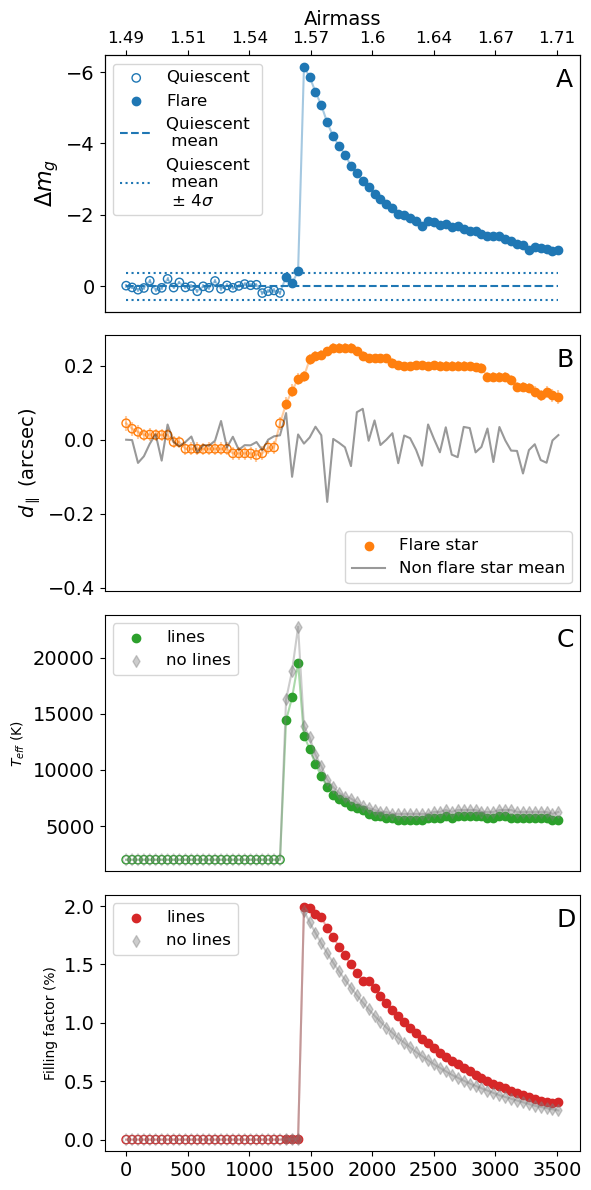

In [968]:
fig, axes = plt.subplots(4,1, figsize=(6,12))

ax = axes.flatten()


magerrs = np.load('Outdata/SEmagerrs.npy')

ax[0].errorbar(tSec, delta_g_mag, yerr = magerrs, alpha=0.4, color='C0', ls='None')
ax[0].scatter(tSec[~finds], delta_g_mag[~finds], edgecolor='C0', facecolor='None', label='Quiescent')
ax[0].scatter(tSec[finds], delta_g_mag[finds], c='C0', label='Flare')
ax[0].hlines(np.nanmean(delta_g_mag[:np.where(tSec < baseline_npoints)[0][-1]]), 0, tSec[-1], color='C0', ls='--', label='Quiescent \n mean')
ax[0].hlines(np.nanmean(delta_g_mag[:np.where(tSec < baseline_npoints)[0][-1]]) - 
             np.nanstd(delta_g_mag[:np.where(tSec < baseline_npoints)[0][-1]]) * 4, 0, tSec[-1], color='C0', ls=':', label='Quiescent \n mean \n'+r' $\pm$ $4\sigma$')
ax[0].hlines(np.nanmean(delta_g_mag[:np.where(tSec < baseline_npoints)[0][-1]]) + 
             np.nanstd(delta_g_mag[:np.where(tSec < baseline_npoints)[0][-1]]) * 4, 0, tSec[-1], color='C0', ls=':')
ax[0].plot(tSec, delta_g_mag, c='C0', alpha=0.4)
ax[0].set_ylabel(r'$\Delta m_g$', fontsize=16)
ax[0].set_ylim(ax[0].get_ylim()[::-1])
ax[0].legend(loc='upper left', fontsize=12)
ax[0].tick_params(axis='both', labelsize=12)

subax0 = ax[0].twiny()
subax0.set_xticks(ax[0].get_xticks())
subax0.set_xticklabels(np.round(AM[::8], decimals=2), fontsize=12)
subax0.set_xlim(ax[0].get_xlim())
subax0.set_xlabel('Airmass', fontsize=14)

ax[1].errorbar(tSec, dpar_smoothed, yerr = dparerr_smoothed, alpha=0.4, color='C1', ls='None')
ax[1].scatter(tSec[~finds], dpar_smoothed[~finds], edgecolor='C1', facecolor='None')
ax[1].scatter(tSec[finds], dpar_smoothed[finds], c='C1', label='Flare star')
ax[1].plot(tSec, dpar_smoothed, c='C1', alpha=0.4)
ax[1].plot(tSec, np.nanmean(dpar_arr, axis=1) * deg2arcsec, c='k', alpha=0.4, label='Non flare star mean')
#ax[1].fill_between(tSec, (np.nanmean(dpar_arr, axis=1) - np.nanstd(dpar_arr, axis=1)) * deg2arcsec, 
#                   (np.nanmean(dpar_arr, axis=1) + np.nanstd(dpar_arr, axis=1)) * deg2arcsec, color='black', alpha=0.1)
ax[1].set_ylabel(r'$d_{\parallel}$ (arcsec)', fontsize=14)
ax[1].tick_params(axis='both', labelsize=12)
ax[1].legend(fontsize=12, loc='lower right')
ax[1].set_ylim(-0.41, None)

ax[2].scatter(tSec[~finds], np.load('Outdata/flr_teffs3_lines.npy')[~finds], edgecolor='C2', facecolor='None')
ax[2].scatter(tSec[finds], np.load('Outdata/flr_teffs3_lines.npy')[finds], c='C2', label='lines')
ax[2].scatter(tSec[~finds], np.load('Outdata/flr_teffs3_nolines.npy')[~finds], edgecolor='grey', alpha=0.4, marker='d', facecolor='None')
ax[2].scatter(tSec[finds], np.load('Outdata/flr_teffs3_nolines.npy')[finds], c='grey', alpha=0.4, marker='d', label='no lines')
ax[2].plot(tSec, np.load('Outdata/flr_teffs3_lines.npy'), c='C2', alpha=0.4)
ax[2].plot(tSec, np.load('Outdata/flr_teffs3_nolines.npy'), c='grey', ls='-', alpha=0.4)
ax[2].set_ylabel(r'$T_{eff}$ (K)')
ax[2].legend(fontsize=12, loc='upper left')

ax[3].scatter(tSec[~finds], np.load('Outdata/flr_ffs3_lines.npy')[~finds], edgecolor='C3', facecolor='None')
ax[3].scatter(tSec[finds], np.load('Outdata/flr_ffs3_lines.npy')[finds], c='C3', label='lines')
ax[3].scatter(tSec[~finds], np.load('Outdata/flr_ffs3_nolines.npy')[~finds], edgecolor='grey', alpha=0.4, marker='d', facecolor='None')
ax[3].scatter(tSec[finds], np.load('Outdata/flr_ffs3_nolines.npy')[finds], c='grey', alpha=0.4, marker='d', label='no lines')
ax[3].plot(tSec, np.load('Outdata/flr_ffs3_lines.npy'), c='C3', alpha=0.4)
ax[3].plot(tSec, np.load('Outdata/flr_ffs3_nolines.npy'), c='grey', alpha=0.4, ls='-')
ax[3].set_ylabel('Filling factor (%)')
ax[3].legend(fontsize=12, loc='upper left')

for axis, label in zip(ax, ['A', 'B', 'C', 'D']):
    axis.annotate(label, xy=(0.95,0.875), xycoords='axes fraction', fontsize=18)
    axis.tick_params(axis='both', labelsize=14)

    if label is not 'D':
        axis.set_xticks([])

fig.tight_layout()
fig.savefig('Figures/result_grid_vert.png', dpi=300, bbox_inches='tight')

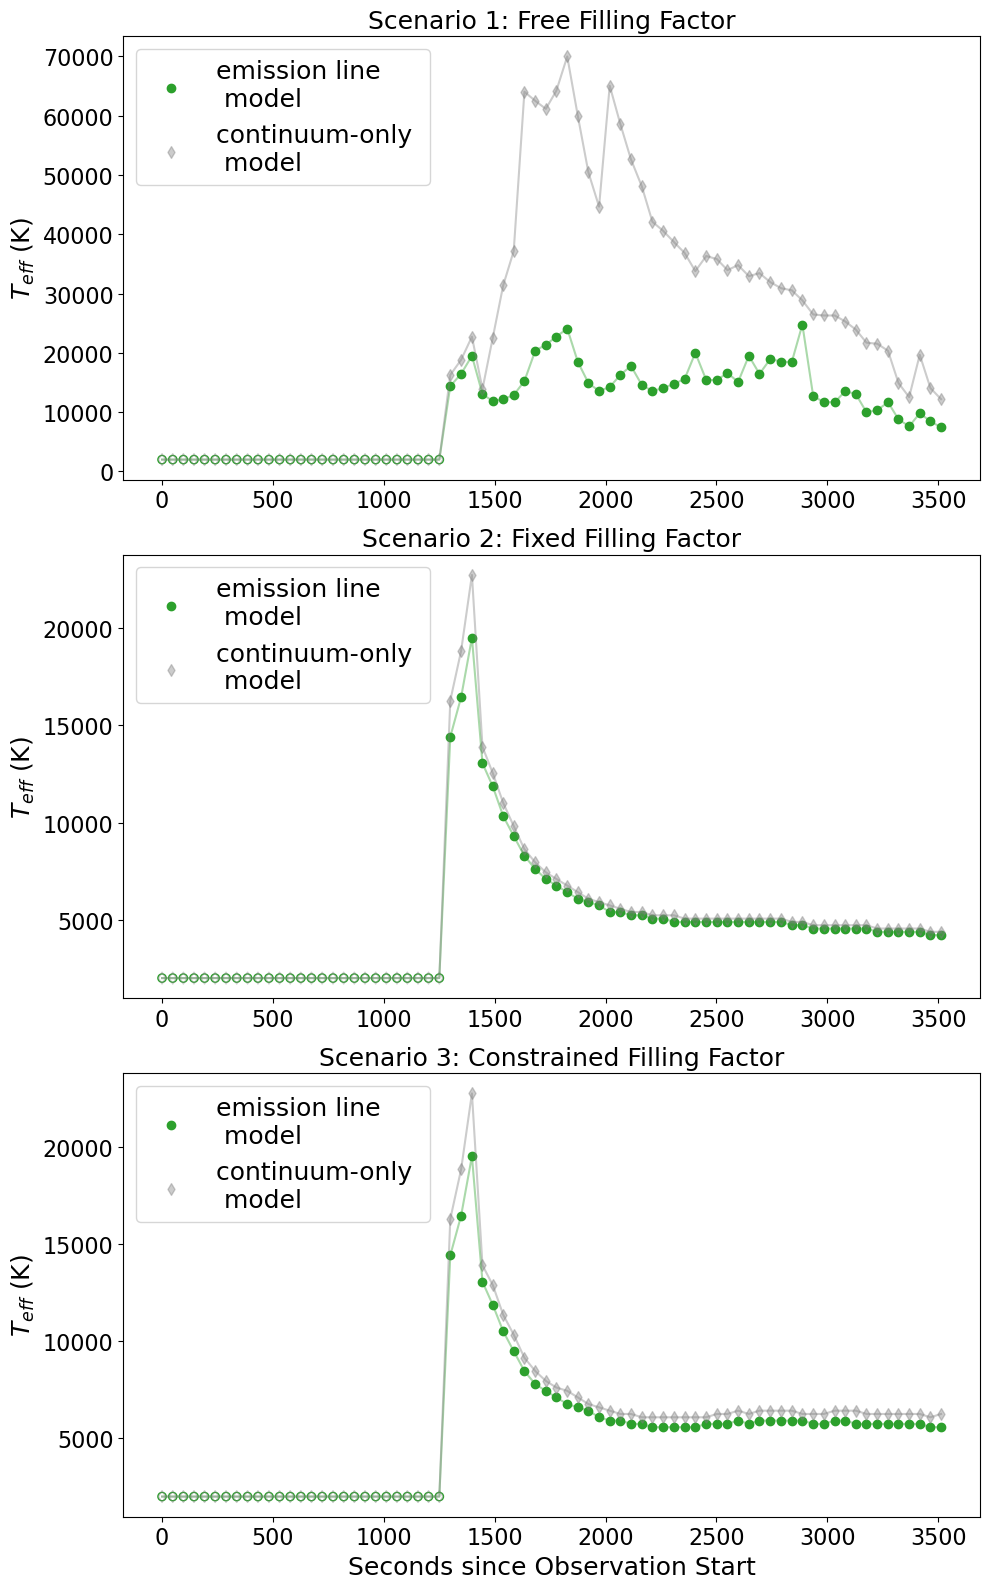

In [969]:
fig, axes = plt.subplots(3,1,figsize=(10,16))
fig.subplots_adjust(hspace=0.4, wspace=0.25)
ax = axes.flatten()

ax[0].scatter(tSec[~finds], np.load('Outdata/flr_teffs1_lines.npy')[~finds], edgecolor='C2', facecolor='None')
ax[0].scatter(tSec[finds], np.load('Outdata/flr_teffs1_lines.npy')[finds], c='C2', label='emission line \n model')
ax[0].scatter(tSec[~finds], np.load('Outdata/flr_teffs1_nolines.npy')[~finds], edgecolor='grey', alpha=0.4, marker='d', facecolor='None')
ax[0].scatter(tSec[finds], np.load('Outdata/flr_teffs1_nolines.npy')[finds], c='grey', alpha=0.4, marker='d', label='continuum-only \n model')
ax[0].plot(tSec, np.load('Outdata/flr_teffs1_lines.npy'), c='C2', alpha=0.4)
ax[0].plot(tSec, np.load('Outdata/flr_teffs1_nolines.npy'), c='grey', ls='-', alpha=0.4)
ax[0].set_ylabel(r'$T_{eff}$ (K)')
ax[0].legend()

ax[1].scatter(tSec[~finds], np.load('Outdata/flr_teffs2_lines.npy')[~finds], edgecolor='C2', facecolor='None')
ax[1].scatter(tSec[finds], np.load('Outdata/flr_teffs2_lines.npy')[finds], c='C2', label='emission line \n model')
ax[1].scatter(tSec[~finds], np.load('Outdata/flr_teffs2_nolines.npy')[~finds], edgecolor='grey', alpha=0.4, marker='d', facecolor='None')
ax[1].scatter(tSec[finds], np.load('Outdata/flr_teffs2_nolines.npy')[finds], c='grey', alpha=0.4, marker='d', label='continuum-only \n model')
ax[1].plot(tSec, np.load('Outdata/flr_teffs2_lines.npy'), c='C2', alpha=0.4)
ax[1].plot(tSec, np.load('Outdata/flr_teffs2_nolines.npy'), c='grey', ls='-', alpha=0.4)
ax[1].set_ylabel(r'$T_{eff}$ (K)')
ax[1].legend()

ax[2].scatter(tSec[~finds], np.load('Outdata/flr_teffs3_lines.npy')[~finds], edgecolor='C2', facecolor='None')
ax[2].scatter(tSec[finds], np.load('Outdata/flr_teffs3_lines.npy')[finds], c='C2', label='emission line \n model')
ax[2].scatter(tSec[~finds], np.load('Outdata/flr_teffs3_nolines.npy')[~finds], edgecolor='grey', alpha=0.4, marker='d', facecolor='None')
ax[2].scatter(tSec[finds], np.load('Outdata/flr_teffs3_nolines.npy')[finds], c='grey', alpha=0.4, marker='d', label='continuum-only \n model')
ax[2].plot(tSec, np.load('Outdata/flr_teffs3_lines.npy'), c='C2', alpha=0.4)
ax[2].plot(tSec, np.load('Outdata/flr_teffs3_nolines.npy'), c='grey', ls='-', alpha=0.4)
ax[2].set_xlabel('Seconds since Observation Start')
ax[2].set_ylabel(r'$T_{eff}$ (K)')
ax[2].legend()


for i, a in enumerate(ax):
    a.tick_params(axis='both', labelsize=16)
    a.xaxis.get_label().set_fontsize(18)
    a.yaxis.get_label().set_fontsize(18)
    a.legend(loc='upper left', fontsize=18)

ax[0].set_title('Scenario 1: Free Filling Factor', fontsize=18)
ax[1].set_title('Scenario 2: Fixed Filling Factor', fontsize=18)
ax[2].set_title('Scenario 3: Constrained Filling Factor', fontsize=18)

fig.tight_layout()

fig.savefig('Figures/result_grid_temponly.png', bbox_inches='tight')

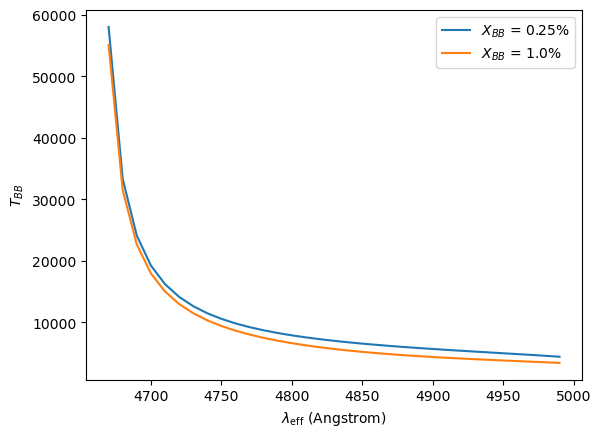

In [973]:
wav = np.arange(4670, 5000, 10)

T1 = np.array([inverseTeff(weff = w, ff = baseline_ff, linefrac = [0.0,0.0]) for w in wav])
T2 = np.array([inverseTeff(weff = w, ff = baseline_ff * 4, linefrac = [0.0,0.0]) for w in wav])

plt.plot(wav, T1, color='C0', label = r'$X_{BB}$ = 0.25%')
plt.plot(wav, T2, color='C1', label=r'$X_{BB}$ = 1.0%')

plt.xlabel(r'$\lambda_\mathrm{eff}$ (Angstrom)')
plt.ylabel(r'$T_{BB}$')
plt.legend()

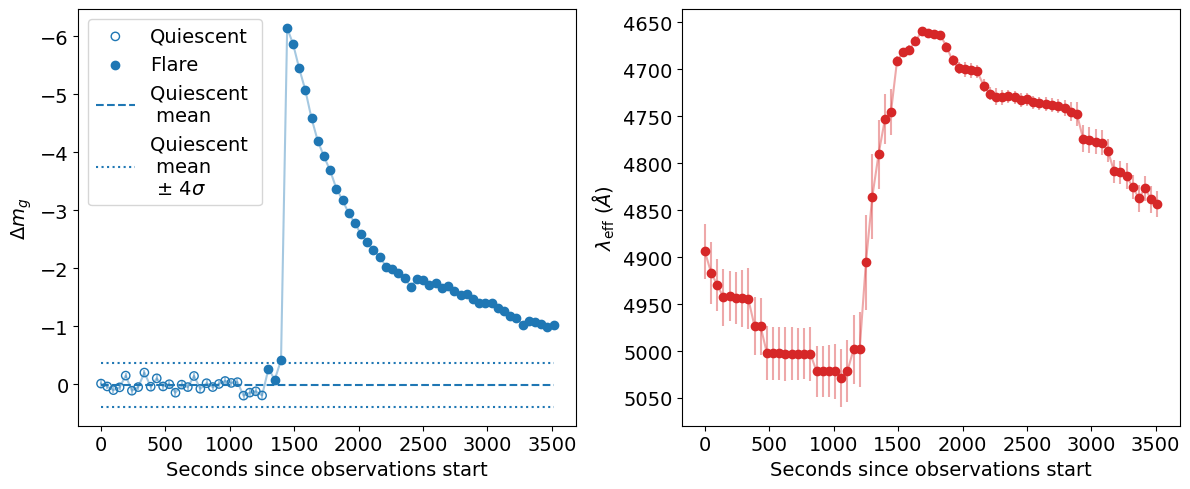

In [974]:
fig, ax = plt.subplots(1,2, figsize=(12,5))

ax[0].errorbar(tSec, delta_g_mag, yerr = magerrs, alpha=0.4, color='C0', ls='None')
ax[0].scatter(tSec[~finds], delta_g_mag[~finds], edgecolor='C0', facecolor='None', label='Quiescent')
ax[0].scatter(tSec[finds], delta_g_mag[finds], c='C0', label='Flare')
ax[0].hlines(np.nanmean(delta_g_mag[:np.where(tSec < baseline_npoints)[0][-1]]), 0, tSec[-1], color='C0', ls='--', label='Quiescent \n mean')
ax[0].hlines(np.nanmean(delta_g_mag[:np.where(tSec < baseline_npoints)[0][-1]]) - 
             np.nanstd(delta_g_mag[:np.where(tSec < baseline_npoints)[0][-1]]) * 4, 0, tSec[-1], color='C0', ls=':', label='Quiescent \n mean \n'+r' $\pm$ $4\sigma$')
ax[0].hlines(np.nanmean(delta_g_mag[:np.where(tSec < baseline_npoints)[0][-1]]) + 
             np.nanstd(delta_g_mag[:np.where(tSec < baseline_npoints)[0][-1]]) * 4, 0, tSec[-1], color='C0', ls=':')
ax[0].plot(tSec, delta_g_mag, c='C0', alpha=0.4)
ax[0].set_ylabel(r'$\Delta m_g$', fontsize=14)
ax[0].legend(loc='upper left', fontsize=14)

ax[1].errorbar(tSec, flr_weffs, yerr = weffErrRadec, ls='None', alpha=0.4, color='C3')
ax[1].scatter(tSec[~finds], flr_weffs[~finds], marker='o', color='C3')
ax[1].scatter(tSec[finds], flr_weffs[finds], marker='o', color='C3')
ax[1].plot(tSec, flr_weffs, color='C3', alpha = 0.4)
ax[1].set_ylabel(r'$\lambda_\mathrm{eff}$ ($\AA$)', fontsize=14)

for a in ax:
    a.tick_params(axis='both', labelsize=14)
    a.set_xlabel('Seconds since observations start', fontsize=14)
    a.set_ylim(a.get_ylim()[::-1])

fig.tight_layout()

plt.savefig('Figures/lightcurve+weffs.png', dpi=300, bbox_inches='tight')